In [42]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV,RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor


# Cargar datos
df_offense = pd.read_csv('/Users/AlexLaugesen/repos/TFG1/venv/FINAL_DATA_offense.csv')
df_defense = pd.read_csv('/Users/AlexLaugesen/repos/TFG1/venv/FINAL_DATA_defense.csv')

In [34]:
# Función para evaluar y obtener métricas
def get_metrics(model, X_tr, y_tr, X_te, y_te):
    model.fit(X_tr, y_tr)
    pred_tr = model.predict(X_tr)
    pred_te = model.predict(X_te)
    metrics = {
        'Train_MAE': mean_absolute_error(y_tr, pred_tr),
        'Train_RMSE': np.sqrt(mean_squared_error(y_tr, pred_tr)),
        'Train_R2': r2_score(y_tr, pred_tr),
        'Test_MAE': mean_absolute_error(y_te, pred_te),
        'Test_RMSE': np.sqrt(mean_squared_error(y_te, pred_te)),
        'Test_R2': r2_score(y_te, pred_te)
    }
    # Importancia de variables
    if hasattr(model, 'feature_importances_'):
        imp = model.feature_importances_
    else:
        score = model.get_booster().get_score(importance_type='weight')
        imp = np.array([score.get(f, 0) for f in X_tr.columns])
    metrics['Importances'] = pd.Series(imp, index=X_tr.columns)
    return metrics, pred_te

# Funciones de gráfico
def plot_errors(y_true, y_pred, title):
    plt.figure()
    plt.hist(y_true - y_pred, bins=30)
    plt.title(title)
    plt.xlabel('Error')
    plt.ylabel('Frequency')
    plt.show()


def plot_real_pred(y_true, y_pred, title):
    plt.figure()
    plt.scatter(y_true, y_pred, alpha=0.6)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.title(title)
    plt.xlabel('Real')
    plt.ylabel('Predicted')
    plt.show()


def plot_importances(imps, title, top_n=10):
    plt.figure(figsize=(8,6))
    idx = np.argsort(imps.values)[-top_n:]
    colors = plt.cm.tab10(np.linspace(0, 1, len(idx)))
    plt.barh(imps.index[idx], imps.values[idx], color=colors)    
    plt.title(title)
    plt.xlabel('Importance')
    plt.show()
    

def table_top_bottom(imps, n=10):
    sorted_imps = imps.sort_values()
    bottom = sorted_imps.head(n).reset_index()
    bottom.columns = ['Variable', 'BottomImportance']
    top = sorted_imps.tail(n).reset_index()
    top.columns = ['Variable', 'TopImportance']
    table = pd.concat([bottom, top], axis=1)
    return table    


def plot_corr(X, title):
    corr_df = X.drop(columns=[c for c in X.columns if c.startswith('Draft')], errors='ignore')
    corr = corr_df.corr()
    plt.figure(figsize=(10,8))
    plt.imshow(corr, interpolation='none', aspect='auto')
    plt.colorbar()
    plt.title(title)
    plt.xticks(range(len(corr)), corr.columns, rotation=90)
    plt.yticks(range(len(corr)), corr.index)
    plt.tight_layout()
    plt.show()

# Evaluación Ofensiva

--- Offense DecisionTree ---
                Value
Train_MAE    0.000000
Train_RMSE   0.000000
Train_R2     1.000000
Test_MAE    16.354781
Test_RMSE   21.401894
Test_R2     -0.076452
Cross-Validated R2 (mean ± std): -0.3477 ± 0.2717
Top 10 y Bottom 10 Importances:
        Variable  BottomImportance  Variable  TopImportance
0        Def_Int               0.0  Vertical       0.033627
1             Sk               0.0  Rush_Y/A       0.035669
2  DraftTeam_KAN               0.0     Broad       0.035852
3          Pos_S               0.0       Rec       0.036992
4         Pos_LB               0.0        40       0.037649
5         Pos_DT               0.0   Rec_Yds       0.038018
6         Pos_DE               0.0  Pass_Inc       0.045233
7         Pos_CB               0.0  Rush_Att       0.056328
8  DraftTeam_CLT               0.0  Rush_Yds       0.063771
9  DraftTeam_GNB               0.0      Pick       0.313733


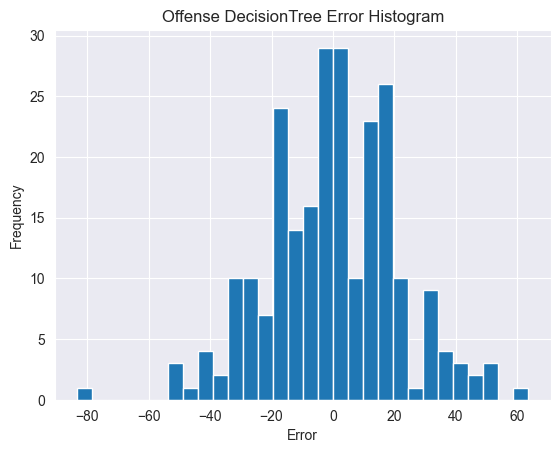

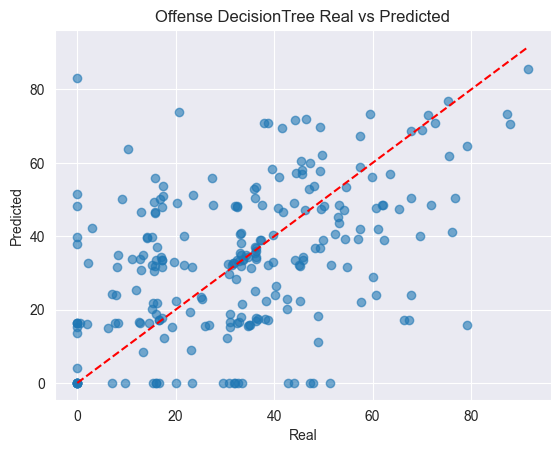

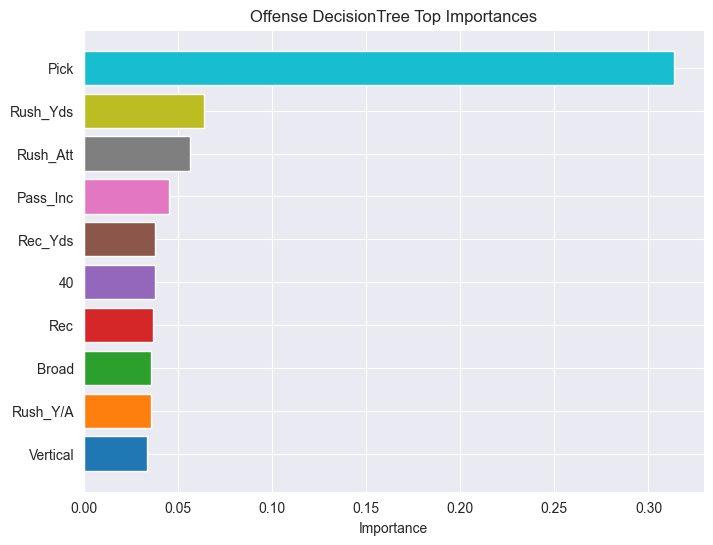

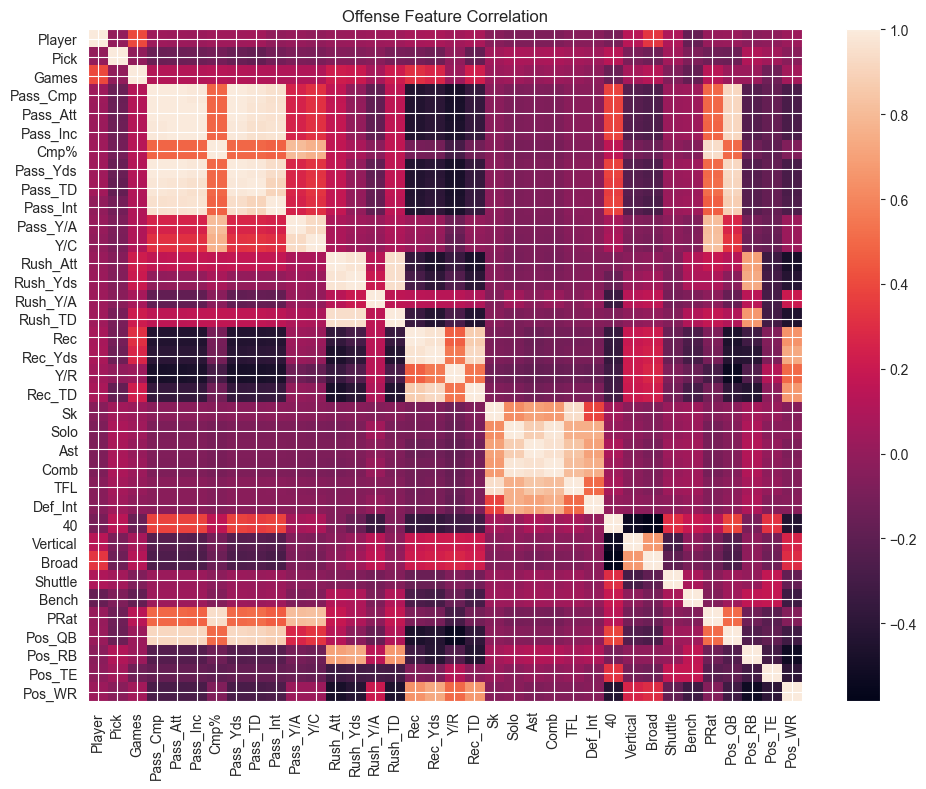

--- Offense RandomForest ---
                Value
Train_MAE    4.975901
Train_RMSE   6.354794
Train_R2     0.907170
Test_MAE    13.071767
Test_RMSE   16.598547
Test_R2      0.352514
Cross-Validated R2 (mean ± std): 0.3391 ± 0.0518
Top 10 y Bottom 10 Importances:
                        Variable  BottomImportance  Variable  TopImportance
0                         Pos_LB               0.0   Shuttle       0.024508
1                         Pos_DT               0.0       Y/R       0.024669
2                         Pos_DE               0.0  Rush_Y/A       0.025493
3                          Pos_S               0.0     Broad       0.027960
4                         Pos_CB               0.0     Bench       0.029940
5        DraftCollege_Ball State               0.0    Player       0.032886
6         DraftCollege_Air Force               0.0        40       0.033196
7  DraftCollege_Louisiana-Monroe               0.0  Rush_Yds       0.039589
8  DraftCollege_Coastal Carolina               0.0  

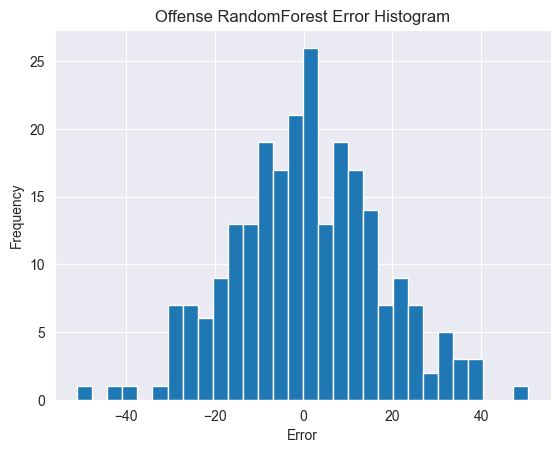

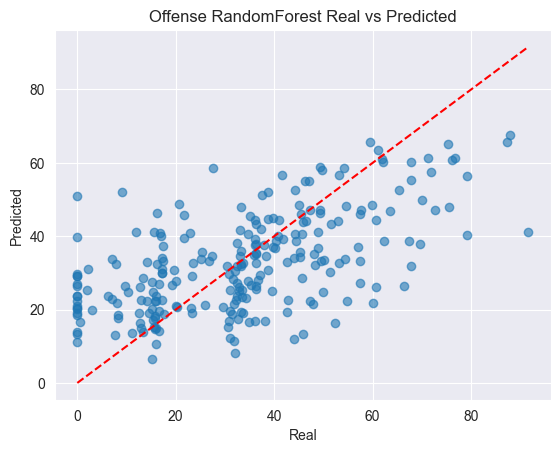

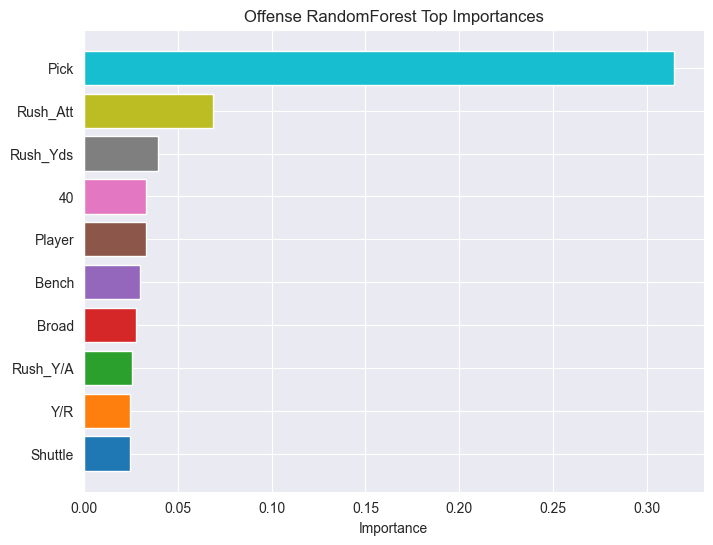

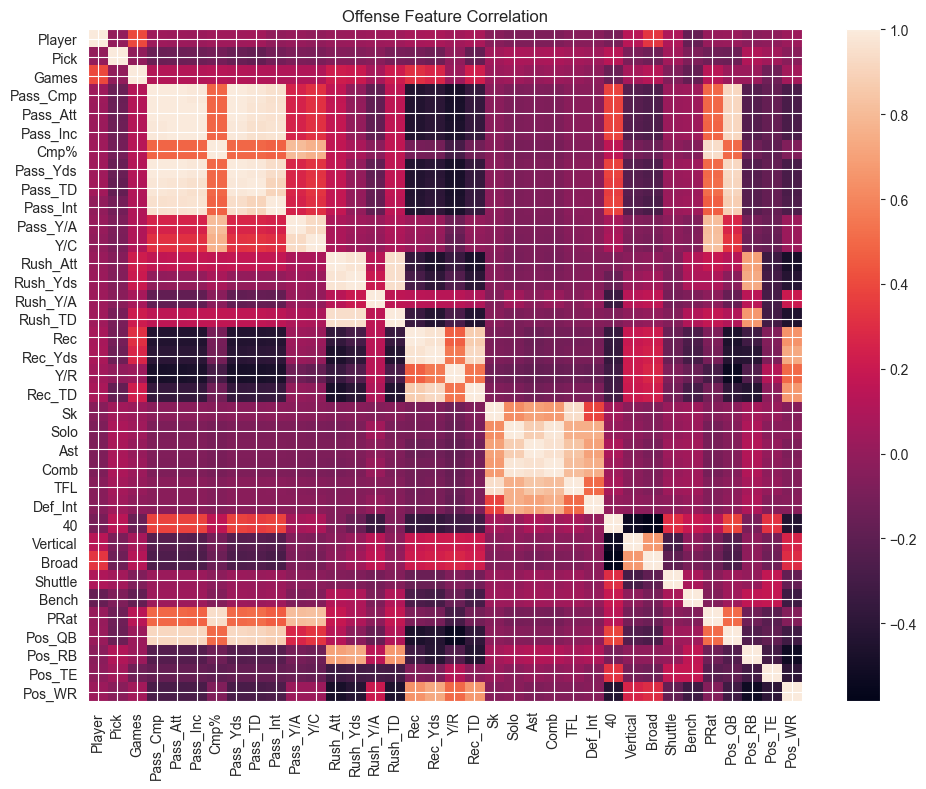

--- Offense XGBoost ---
                Value
Train_MAE    1.428108
Train_RMSE   1.990510
Train_R2     0.990892
Test_MAE    13.963151
Test_RMSE   17.774413
Test_R2      0.257527
Cross-Validated R2 (mean ± std): 0.2413 ± 0.0606
Top 10 y Bottom 10 Importances:
                     Variable  BottomImportance              Variable  \
0                      Pos_LB               0.0         DraftTeam_SFO   
1                      Pos_DT               0.0              Rush_Att   
2                      Pos_DE               0.0         DraftTeam_DEN   
3                       Pos_S               0.0  DraftCollege_Houston   
4                      Pos_CB               0.0            Draft Year   
5      DraftCollege_Charlotte               0.0                  Pick   
6     DraftCollege_California               0.0         DraftTeam_CLT   
7  DraftCollege_East Carolina               0.0              Pass_Inc   
8        DraftCollege_Indiana               0.0               Pass_TD   
9         D

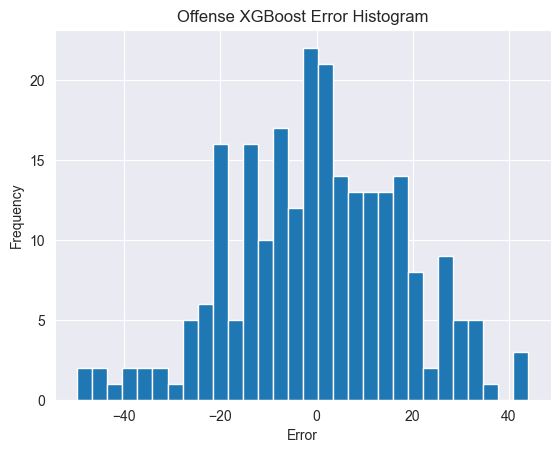

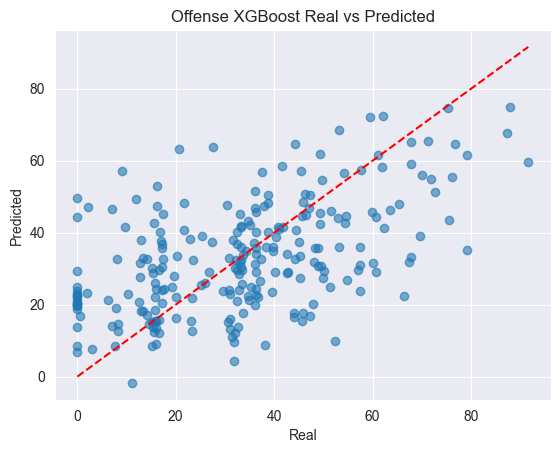

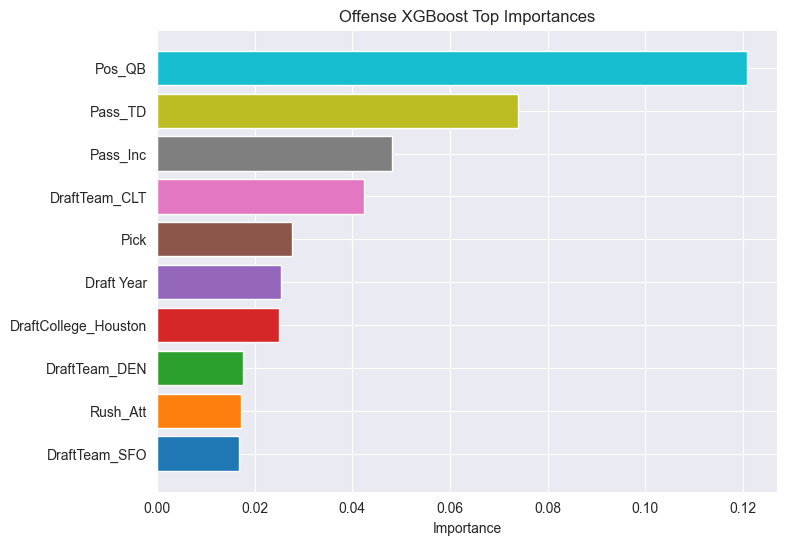

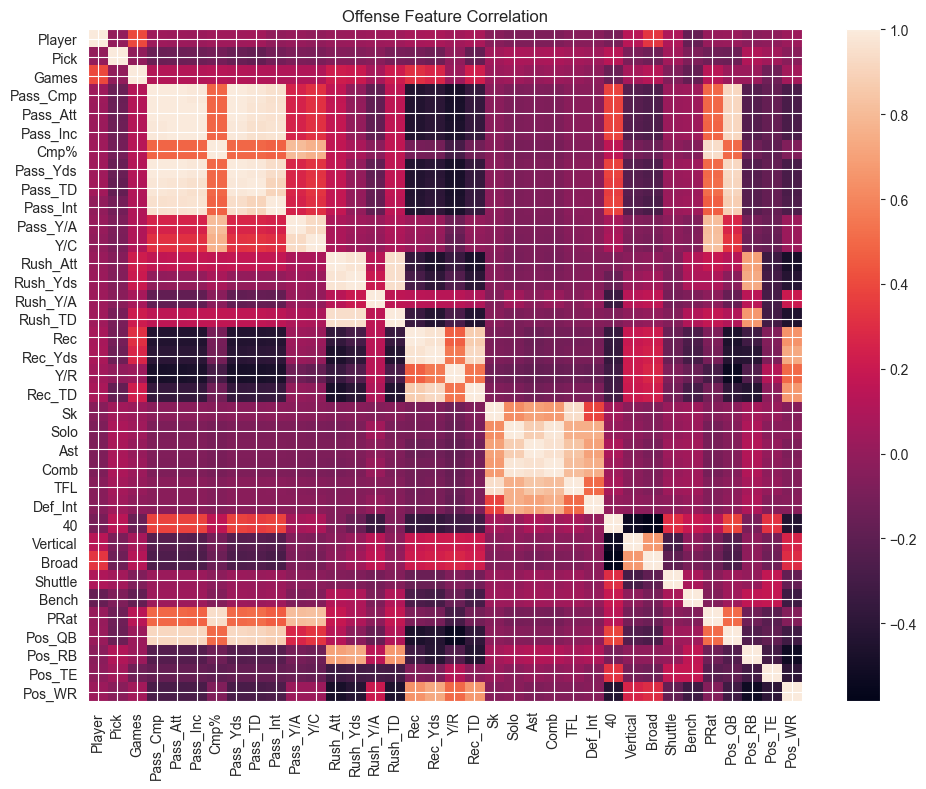

In [35]:
# ======================
# Evaluación Ofensiva
# ======================

df_off = pd.read_csv('/Users/AlexLaugesen/repos/TFG1/venv/FINAL_DATA_offense.csv')
df_off = df_off.drop(columns=['QPR'], errors='ignore')
off_cols = [c for c in df_off.columns if not c.startswith('NFL') and c not in ['Performance', 'QPR']]
X_off = df_off[off_cols]
y_off = df_off['Performance']
X_off_train, X_off_test, y_off_train, y_off_test = train_test_split(
    X_off, y_off, test_size=0.2, random_state=42)

# Definir modelos ofensivos
off_models = {
    'DecisionTree': DecisionTreeRegressor(random_state=42),
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42, objective='reg:squarederror')
}
off_results = {}

for name, model in off_models.items():
    metrics, pred = get_metrics(model, X_off_train, y_off_train, X_off_test, y_off_test)
    # Separar importances de las métricas
    importances = metrics.pop('Importances')
    off_results[name] = {'metrics': metrics, 'importances': importances}

    print(f"--- Offense {name} ---")
    # Mostrar tabla de métricas
    df_metrics = pd.DataFrame(metrics, index=['Value']).T
    print(df_metrics)
    
    # Evaluación con validación cruzada (R2)
    cv_scores = cross_val_score(model, X_off, y_off, cv=5, scoring='r2')
    print(f"Cross-Validated R2 (mean ± std): {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")
    
    # Tabla Top y Bottom 10 importancias
    imp_table = table_top_bottom(importances, n=10)
    print("Top 10 y Bottom 10 Importances:")
    print(imp_table)

    # Gráficos
    plot_errors(y_off_test, pred, f"Offense {name} Error Histogram")
    plot_real_pred(y_off_test, pred, f"Offense {name} Real vs Predicted")
    plot_importances(importances, f"Offense {name} Top Importances")
    # Matriz de correlación solo para variables ofensivas (excluye Draft y posiciones defensivas)
    def_cols_off_corr = [c for c in X_off.columns 
                        if not c.startswith('Draft') 
                        and c not in ['Pos_CB', 'Pos_S', 'Pos_LB', 'Pos_DT', 'Pos_DE']]
    plot_corr(X_off[def_cols_off_corr], "Offense Feature Correlation")

# Evaluación Defensiva

--- Defense DecisionTree ---
                   Value
Train_MAE   2.044610e-19
Train_RMSE  4.764423e-18
Train_R2    1.000000e+00
Test_MAE    2.538767e+01
Test_RMSE   3.364599e+01
Test_R2    -2.348817e-01
Cross-Validated R2 (mean ± std): -0.3996 ± 0.1312
Top 10 y Bottom 10 Importances:
   Variable  BottomImportance  Variable  TopImportance
0      Cmp%               0.0        40       0.022944
1  Pass_Cmp               0.0     Games       0.029196
2   Pass_TD               0.0      Comb       0.029312
3       Y/C               0.0      Solo       0.029566
4  Pass_Y/A               0.0  Vertical       0.030212
5  Pass_Int               0.0   Shuttle       0.036368
6  Pass_Yds               0.0       TFL       0.045073
7   Rush_TD               0.0       Ast       0.047107
8    Pos_TE               0.0    Player       0.071516
9    Pos_WR               0.0      Pick       0.310239


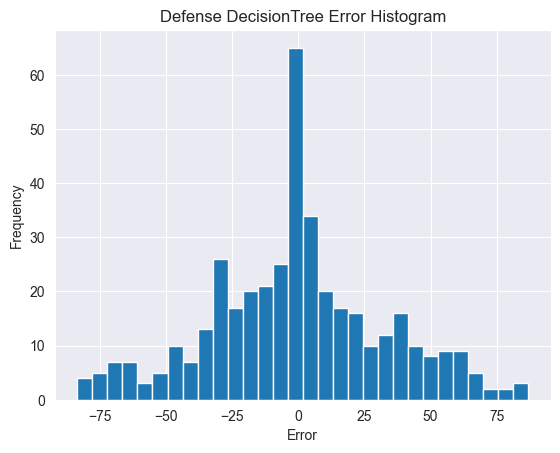

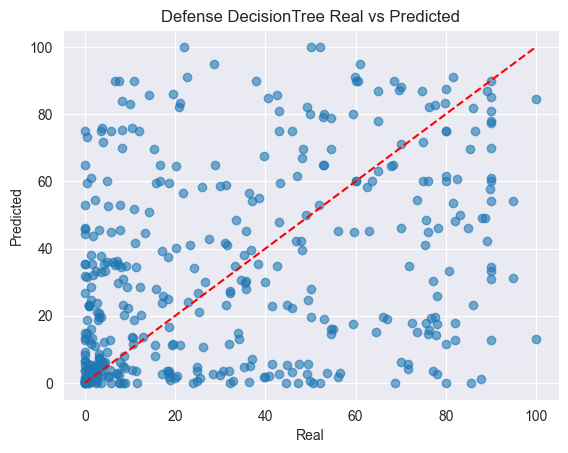

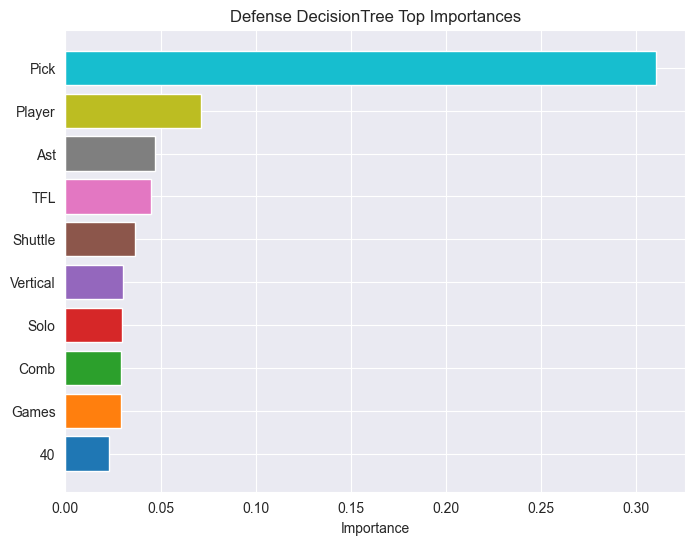

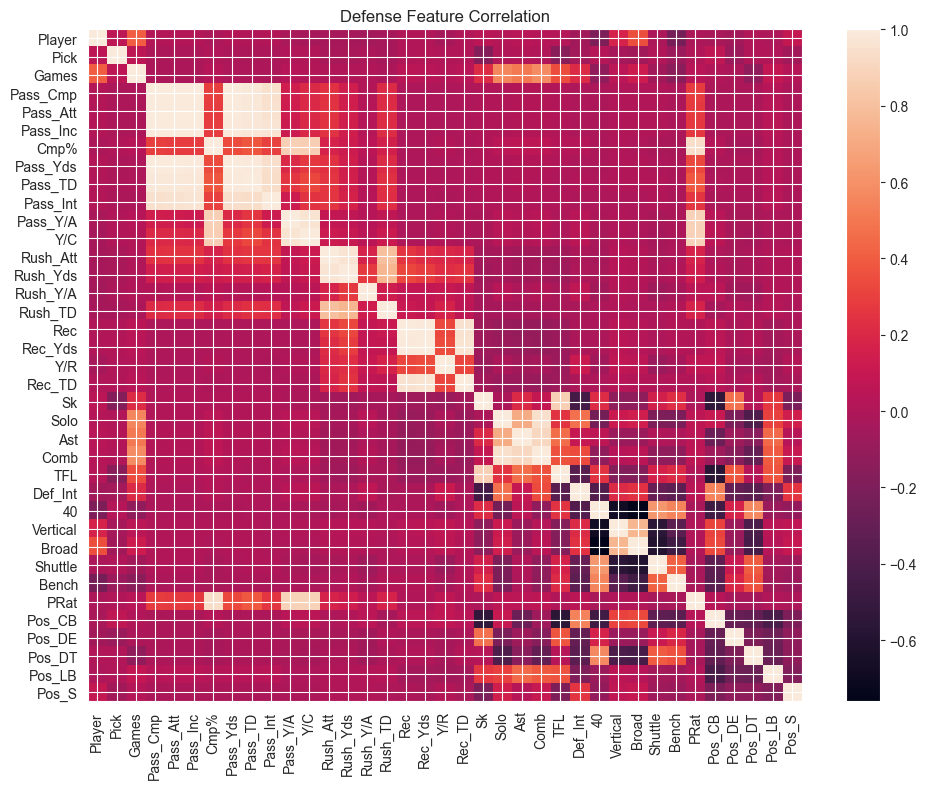

--- Defense RandomForest ---
                Value
Train_MAE    7.618177
Train_RMSE   9.563092
Train_R2     0.895584
Test_MAE    18.792464
Test_RMSE   23.396434
Test_R2      0.402885
Cross-Validated R2 (mean ± std): 0.2893 ± 0.0788
Top 10 y Bottom 10 Importances:
                     Variable  BottomImportance  Variable  TopImportance
0                    Pass_Int               0.0     Bench       0.031826
1                      Pos_WR               0.0        Sk       0.031946
2                      Pos_QB               0.0     Games       0.032306
3                      Pos_RB               0.0  Vertical       0.033067
4                      Pos_TE               0.0      Comb       0.034994
5        DraftCollege_Liberty               0.0      Solo       0.035576
6  DraftCollege_Georgia State               0.0       TFL       0.040284
7    DraftCollege_North Texas               0.0       Ast       0.040892
8  DraftCollege_South Alabama               0.0    Player       0.050435
9    D

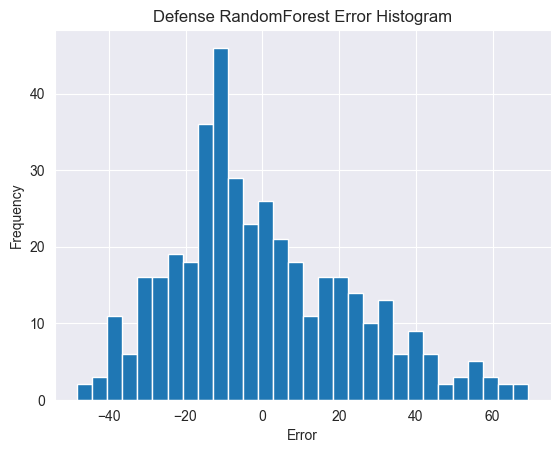

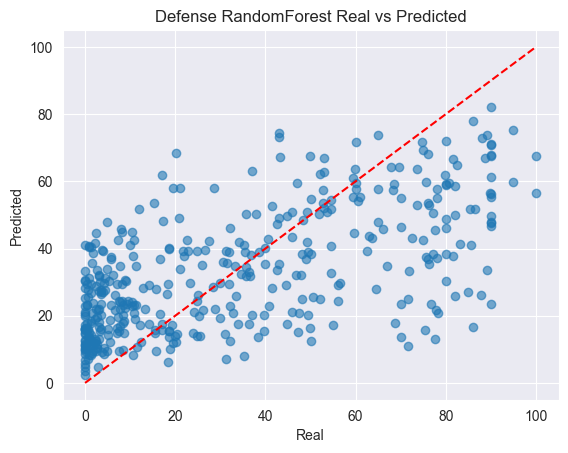

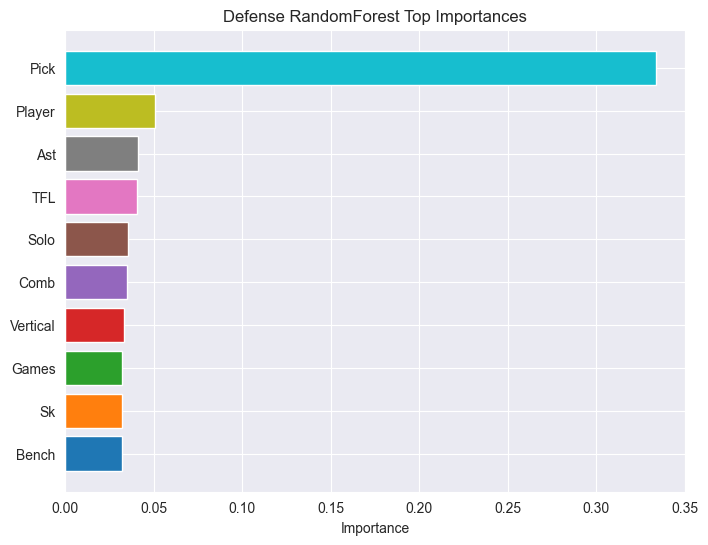

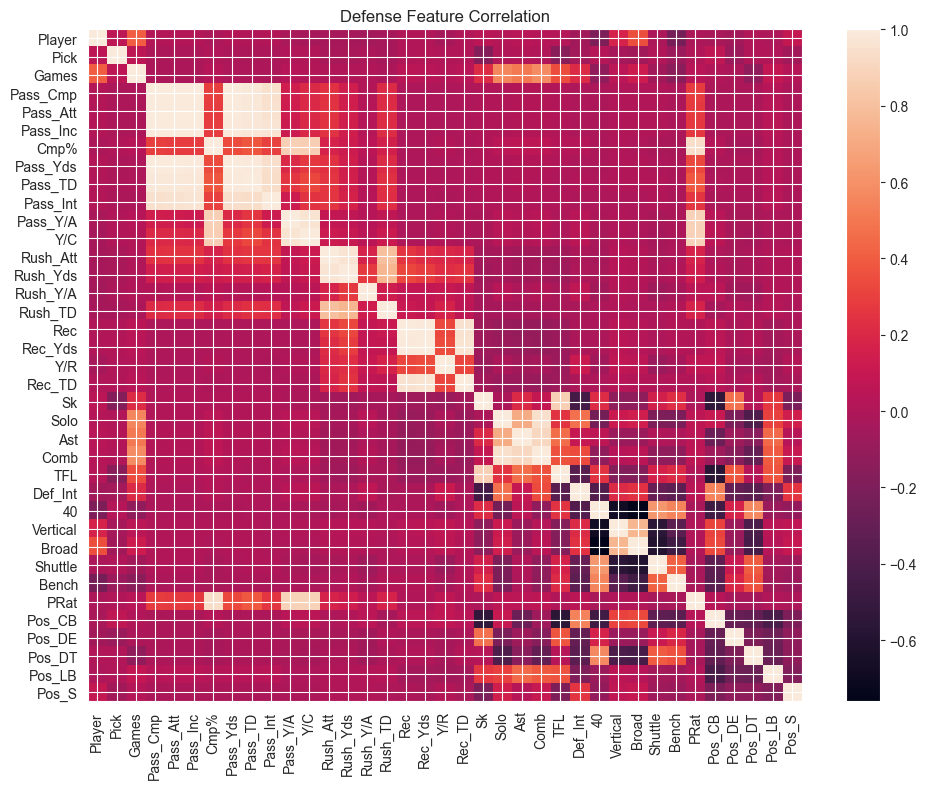

--- Defense XGBoost ---
                Value
Train_MAE    5.268431
Train_RMSE   7.108718
Train_R2     0.942303
Test_MAE    20.001407
Test_RMSE   24.978707
Test_R2      0.319389
Cross-Validated R2 (mean ± std): 0.1731 ± 0.0907
Top 10 y Bottom 10 Importances:
     Variable  BottomImportance                     Variable  TopImportance
0  Draft Year               0.0                       Pos_LB       0.014390
1    Pass_Cmp               0.0        DraftCollege_Michigan       0.015728
2        Cmp%               0.0        DraftCollege_Kentucky       0.020261
3    Pass_Y/A               0.0  DraftCollege_South Carolina       0.021332
4    Pass_Int               0.0                DraftTeam_CAR       0.022045
5         Y/C               0.0            DraftCollege_UCLA       0.023003
6      Pos_QB               0.0                DraftTeam_TAM       0.023652
7        PRat               0.0                        Pos_S       0.025325
8      Pos_TE               0.0                         P

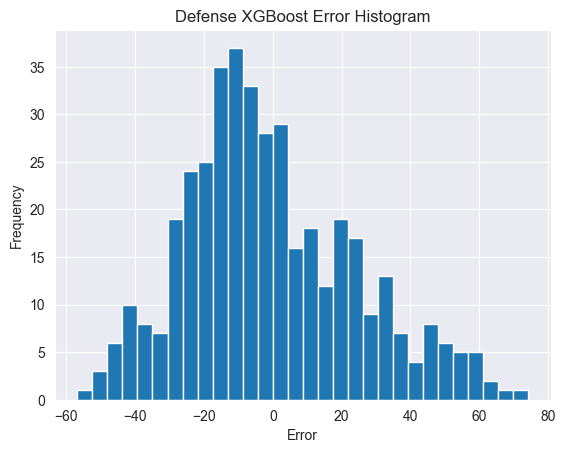

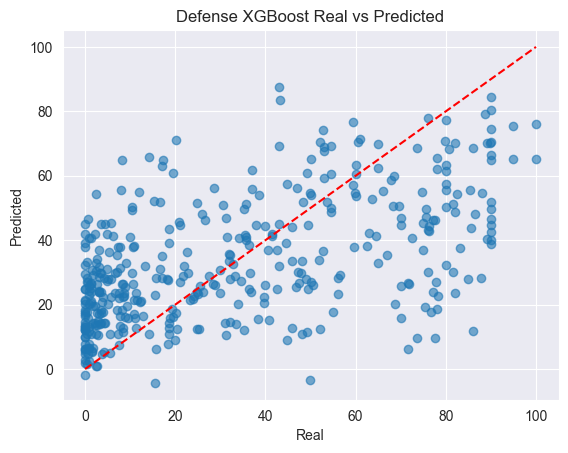

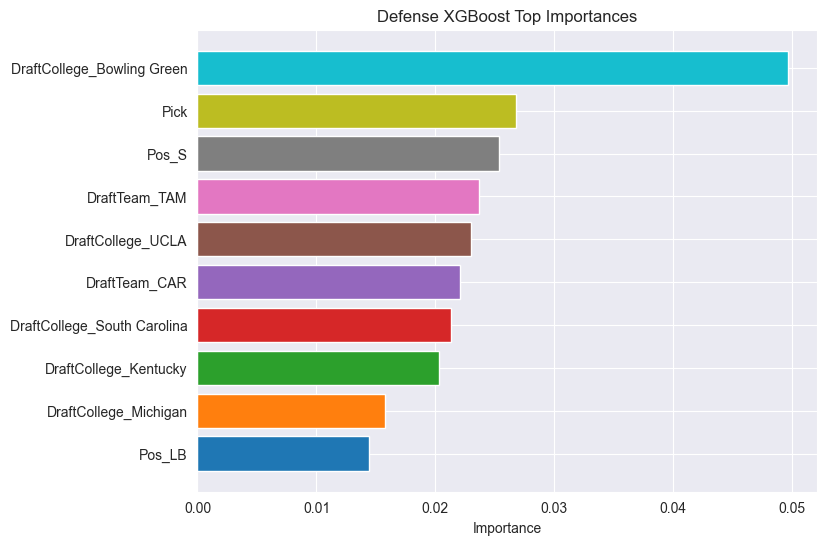

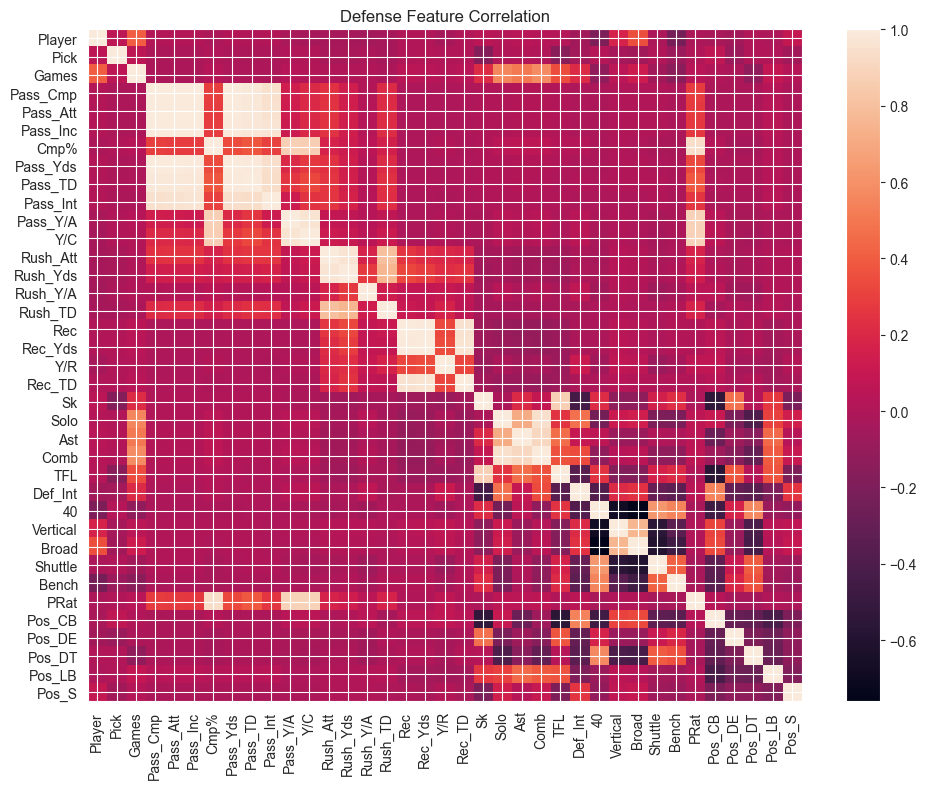

Fin de evaluaciones.


In [36]:
# ======================
# Evaluación Defensiva
# ======================

df_def = pd.read_csv('/Users/AlexLaugesen/repos/TFG1/venv/FINAL_DATA_defense.csv')
df_def = df_def.drop(columns=['QPR'], errors='ignore')
def_cols = [c for c in df_def.columns if not c.startswith('NFL') and c not in ['Performance', 'QPR']]
X_def = df_def[def_cols]
y_def = df_def['Performance']
X_def_train, X_def_test, y_def_train, y_def_test = train_test_split(
    X_def, y_def, test_size=0.2, random_state=42)

# Definir modelos defensivos
def_models = {
    'DecisionTree': DecisionTreeRegressor(random_state=42),
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42, objective='reg:squarederror')
}
def_results = {}

for name, model in def_models.items():
    metrics, pred = get_metrics(model, X_def_train, y_def_train, X_def_test, y_def_test)
    # Separar importances de las métricas
    importances = metrics.pop('Importances')
    def_results[name] = {'metrics': metrics, 'importances': importances}

    print(f"--- Defense {name} ---")
    # Mostrar tabla de métricas
    df_metrics = pd.DataFrame(metrics, index=['Value']).T
    print(df_metrics)
    
    # Evaluación con validación cruzada (R2)
    cv_scores = cross_val_score(model, X_def, y_def, cv=5, scoring='r2')
    print(f"Cross-Validated R2 (mean ± std): {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")
    
    # Tabla Top y Bottom 10 importancias
    imp_table = table_top_bottom(importances, n=10)
    print("Top 10 y Bottom 10 Importances:")
    print(imp_table)

    # Gráficos
    plot_errors(y_def_test, pred, f"Defense {name} Error Histogram")
    plot_real_pred(y_def_test, pred, f"Defense {name} Real vs Predicted")
    plot_importances(importances, f"Defense {name} Top Importances")
    
    # Matriz de correlación solo para variables defensivas (excluye Draft y posiciones ofensivas)
    def_cols_def_corr = [c for c in X_def.columns 
                         if not c.startswith('Draft') 
                         and c not in ['Pos_QB', 'Pos_RB', 'Pos_WR', 'Pos_TE']]
    plot_corr(X_def[def_cols_def_corr], "Defense Feature Correlation")


print('Fin de evaluaciones.')

# ===============
# Refinar modelos
# ===============

In [93]:
# ======================
# Refinamiento Ofensiva: Eliminar estadísticas defensivas irrelevantes
# ======================
 
irrelevant_def_vars = ['Sk', 'Solo', 'Ast', 'Comb', 'TFL', 'Def_Int', 'QPR', 'Pos_CB', 'Pos_S', 'Pos_LB', 'Pos_DT', 'Pos_DE', 'Player']
off_refined_cols = [c for c in X_off.columns if not c.startswith('NFL') and c not in irrelevant_def_vars]
X_off_refined = X_off[off_refined_cols]

X_off_train_ref, X_off_test_ref, y_off_train_ref, y_off_test_ref = train_test_split(
    X_off_refined, y_off, test_size=0.2, random_state=42
)

print("\n==== Modelos ofensivos refinados ====")
for name, model in off_models.items():
    # Pipeline: escalado + modelo
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)
    ])
    
    # Validación cruzada con pipeline
    cv_scores = cross_val_score(pipeline, X_off_refined, y_off, cv=5, scoring='r2')
    print(f"\n--- OFFENSE (Refined) {name} ---")
    print(f"Cross-Validated R2 (mean ± std): {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")
    
    # Entrenamiento final para métricas fuera de CV
    pipeline.fit(X_off_train_ref, y_off_train_ref)
    pred = pipeline.predict(X_off_test_ref)
    metrics = {
        'Train_MAE': mean_absolute_error(y_off_train_ref, pipeline.predict(X_off_train_ref)),
        'Train_RMSE': np.sqrt(mean_squared_error(y_off_train_ref, pipeline.predict(X_off_train_ref))),
        'Train_R2': r2_score(y_off_train_ref, pipeline.predict(X_off_train_ref)),
        'Test_MAE': mean_absolute_error(y_off_test_ref, pred),
        'Test_RMSE': np.sqrt(mean_squared_error(y_off_test_ref, pred)),
        'Test_R2': r2_score(y_off_test_ref, pred)
    }
    print(pd.DataFrame(metrics, index=['Value']).T)


==== Modelos ofensivos refinados ====

--- OFFENSE (Refined) DecisionTree ---
Cross-Validated R2 (mean ± std): 0.2945 ± 0.0539
                Value
Train_MAE   12.516317
Train_RMSE  15.711122
Train_R2     0.432584
Test_MAE    14.215870
Test_RMSE   17.995008
Test_R2      0.238983


KeyboardInterrupt: 

Decision Tree

In [ ]:
# Random Search - Decision Tree

dt_params = {
    'max_depth': [8, 5, 9, 11, 7, 10, 12],
    'min_samples_split': [110, 150, 125, 100, 135],
    'min_samples_leaf': [15, 20, 10, 25, 30, 50]
}

dt_rand = RandomizedSearchCV(
    DecisionTreeRegressor(random_state=42),
    param_distributions=dt_params,
    n_iter=50,
    cv=5,
    scoring='r2',
    n_jobs=-1
)
dt_rand.fit(X_off_train_ref, y_off_train_ref)

print("Best DecisionTree params:", dt_rand.best_params_)
print("Best CV R2:", dt_rand.best_score_)

In [ ]:
# Grid Search - Decision Tree

dt_params = {
    'max_depth': [10, 9, 11, 12, 8],
    'min_samples_leaf': [7, 6, 5, 8],
    'min_samples_split': [115, 125, 120, 130, 135]
}

dt_grid = GridSearchCV(
    DecisionTreeRegressor(random_state=42),
    param_grid=dt_params,
    cv=5,
    scoring='r2',
    n_jobs=-1,
)
dt_grid.fit(X_off_train_ref, y_off_train_ref)

print("Best DecisionTree params:", dt_grid.best_params_)
print("Best CV R2:", dt_grid.best_score_)

Random Forest

In [ ]:
# Random Search - Random Forest
rf_params = {
    'n_estimators': [100, 1000, 500, 10, 400, 50],
    'max_depth': [None, 5, 10, 20, 30, 15, 50],
    'min_samples_split': [2, 5, 10, 50, 15],
    'min_samples_leaf': [100, 2, 75, 50, 10],
    'max_features': ['sqrt', 'log2', None]
}

rf_rands = RandomizedSearchCV(
    RandomForestRegressor(random_state=42),
    param_distributions=rf_params,
    n_iter=50,  
    scoring='r2',
    cv=5,
    n_jobs=-1,
    random_state=42
)
rf_rands.fit(X_off_train_ref, y_off_train_ref)

print("Best RandomForest params:", rf_rands.best_params_)
print("Best CV R2:", rf_rands.best_score_)

In [ ]:
# Grid Search - Random Forest
rf_params = {
    'max_depth': [5],
    'min_samples_leaf': [14],
    'n_estimators': [281, 282, 283],
    'min_samples_split': [5]
}

rf_grid = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid=rf_params,
    cv=5,
    scoring='r2',
    n_jobs=-1,
)
rf_grid.fit(X_off_train_ref, y_off_train_ref)

print("Best RandomForest params:", rf_grid.best_params_)
print("Best CV R2:", rf_grid.best_score_)

XGBoost

In [ ]:
# Random Search - XGBoost
xgb_params = {
    'n_estimators': [100, 200, 500],
    'max_depth': [2, 10, 5, 20],
    'learning_rate': [0.01, 0.05, 0.1, 0.15],
    'subsample': [0.8, 1.0, 0.9, 0.7],
    'colsample_bytree': [0.8, 1.0, 0.9, 0.7],
    'reg_alpha': [0, 0.1, 1],         
    'reg_lambda': [1, 1.5, 2]
}

xgb_rand = RandomizedSearchCV(
    XGBRegressor(random_state=42, objective='reg:squarederror', early_stopping_rounds=10),
    param_distributions=xgb_params,
    cv=5,
    scoring='r2',
    n_jobs=-1
)
xgb_rand.fit(X_off_train_ref, y_off_train_ref, eval_set=[()])

print("Best XGBoost params:", xgb_rand.best_params_)
print("Best CV R2:", xgb_rand.best_score_)


In [ ]:
# Grid Search - XGBoost
xgb_params = {
    'n_estimators': [100, 200, 50],
    'max_depth': [2, 5, 10],
    'learning_rate': [0.15, 0.05, 0.1],
    'subsample': [0.8, 0.7, 0.9],
    'colsample_bytree': [0.8, 0.7, 0.9],
    
}

xgb_grid = GridSearchCV(
    XGBRegressor(random_state=42, objective='reg:squarederror'),
    param_grid=xgb_params,
    cv=5,
    scoring='r2',
    n_jobs=-1
)
xgb_grid.fit(X_off_train_ref, y_off_train_ref)

print("Best XGBoost params:", xgb_grid.best_params_)
print("Best CV R2:", xgb_grid.best_score_)

# =========================
# Evaluación Ofensiva Final
# =========================

--- Offense DecisionTree ---
                Value
Train_MAE   12.516317
Train_RMSE  15.711122
Train_R2     0.432584
Test_MAE    14.215870
Test_RMSE   17.995008
Test_R2      0.238983
Cross-Validated R2 (mean ± std): 0.2954 ± 0.0536
Top 10 y Bottom 10 Importances:
     Variable  BottomImportance                    Variable  TopImportance
0  Draft Year               0.0       DraftCollege_Virginia       0.000000
1       Games               0.0  DraftCollege_Virginia Tech       0.000000
2    Pass_Cmp               0.0      DraftCollege_Wisconsin       0.000000
3    Pass_Att               0.0                         Rec       0.034992
4    Pass_Yds               0.0                       Broad       0.036130
5        Cmp%               0.0                     Rec_Yds       0.052922
6    Pass_Int               0.0                    Rush_Yds       0.068073
7     Pass_TD               0.0                    Pass_Inc       0.096347
8     Rush_TD               0.0                    Rush_Att  

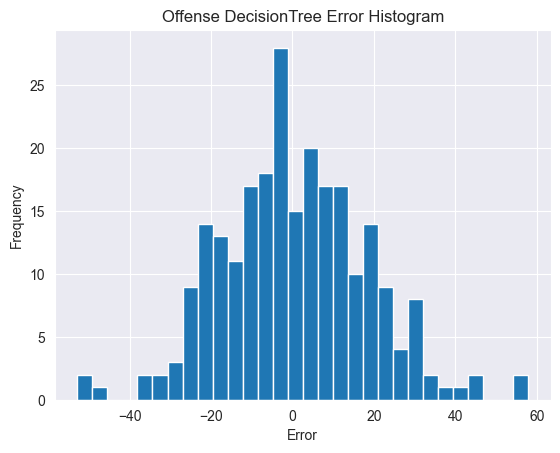

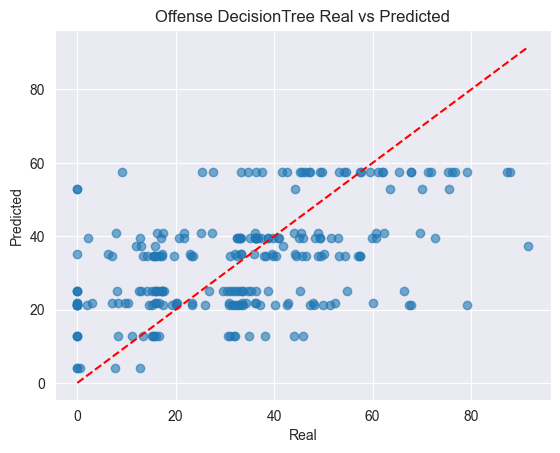

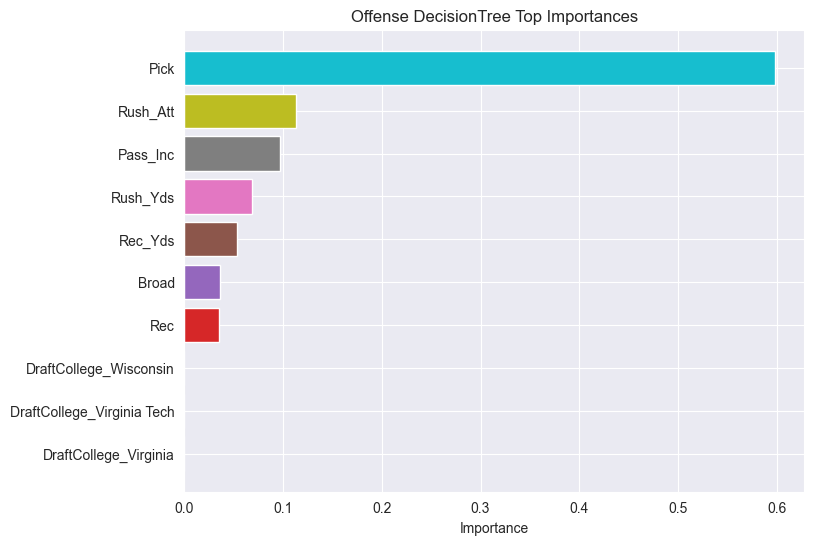

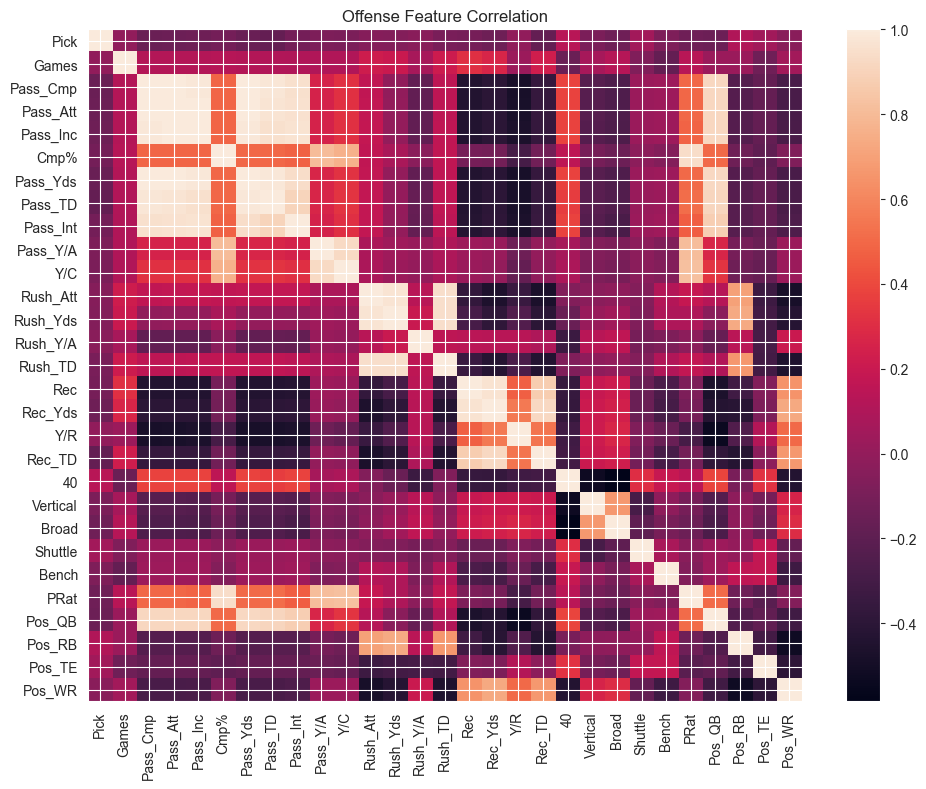

--- Offense RandomForest ---
                Value
Train_MAE   11.534819
Train_RMSE  14.518871
Train_R2     0.515434
Test_MAE    12.788150
Test_RMSE   16.212631
Test_R2      0.382272
Cross-Validated R2 (mean ± std): 0.3593 ± 0.0494
Top 10 y Bottom 10 Importances:
        Variable  BottomImportance    Variable  TopImportance
0  DraftTeam_ATL               0.0     Rec_Yds       0.017564
1  DraftTeam_BUF               0.0       Broad       0.019393
2  DraftTeam_WAS               0.0     Pass_TD       0.019755
3  DraftTeam_TAM               0.0      Pos_QB       0.019896
4  DraftTeam_SFO               0.0    Pass_Cmp       0.024885
5  DraftTeam_SEA               0.0    Pass_Inc       0.026011
6  DraftTeam_SDG               0.0  Draft Year       0.026198
7  DraftTeam_RAV               0.0    Rush_Yds       0.040384
8  DraftTeam_RAM               0.0    Rush_Att       0.106928
9  DraftTeam_RAI               0.0        Pick       0.555210


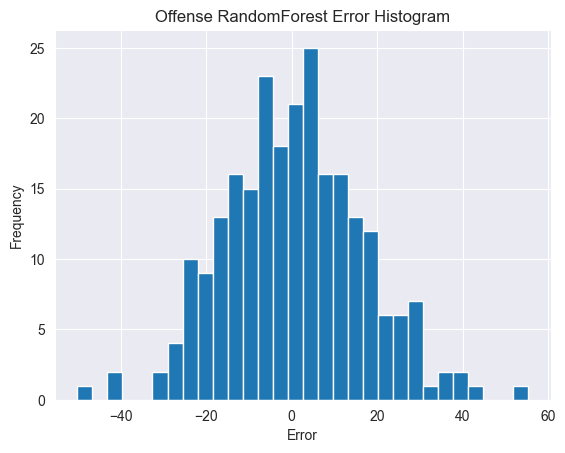

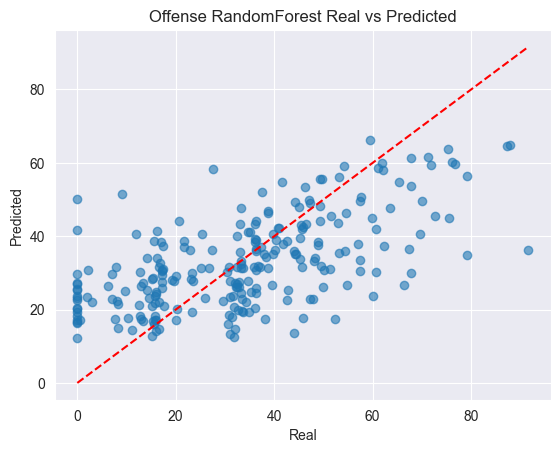

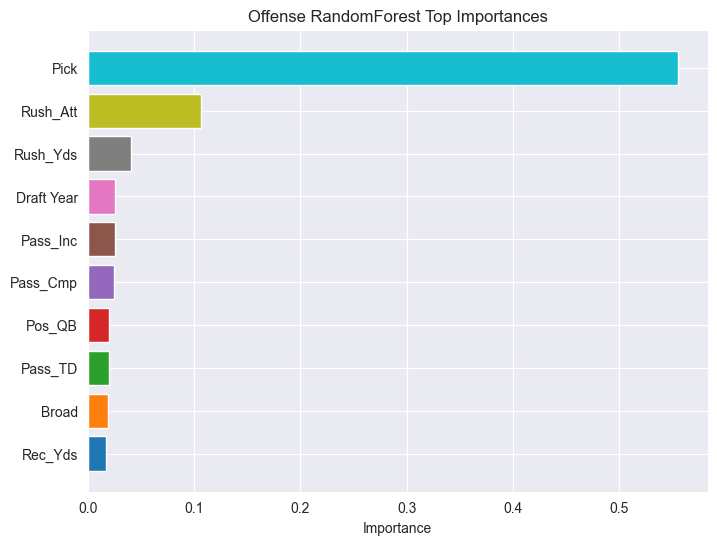

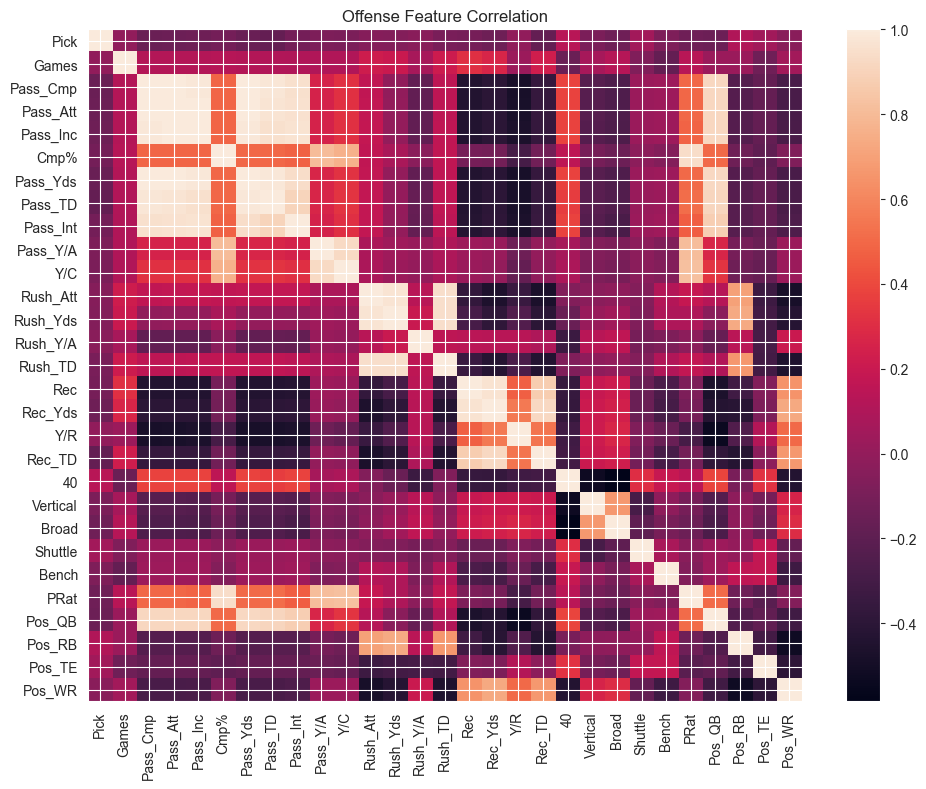

--- Offense XGBoost ---
                Value
Train_MAE   11.737720
Train_RMSE  14.712946
Train_R2     0.502393
Test_MAE    12.832258
Test_RMSE   16.260131
Test_R2      0.378647
Cross-Validated R2 (mean ± std): 0.3577 ± 0.0564
Top 10 y Bottom 10 Importances:
             Variable  BottomImportance  Variable  TopImportance
0              Pos_RB               0.0  Pass_Inc       0.031459
1       DraftTeam_BUF               0.0      Cmp%       0.032735
2       DraftTeam_ATL               0.0  Rush_Y/A       0.033603
3              Pos_WR               0.0  Rush_Yds       0.033848
4             Shuttle               0.0  Rush_Att       0.036797
5       DraftTeam_JAX               0.0   Pass_TD       0.038885
6       DraftTeam_TAM               0.0  Pass_Yds       0.076123
7  DraftCollege_Akron               0.0      Pick       0.082211
8       DraftTeam_SDG               0.0    Pos_QB       0.083979
9       DraftTeam_RAM               0.0  Pass_Cmp       0.097925


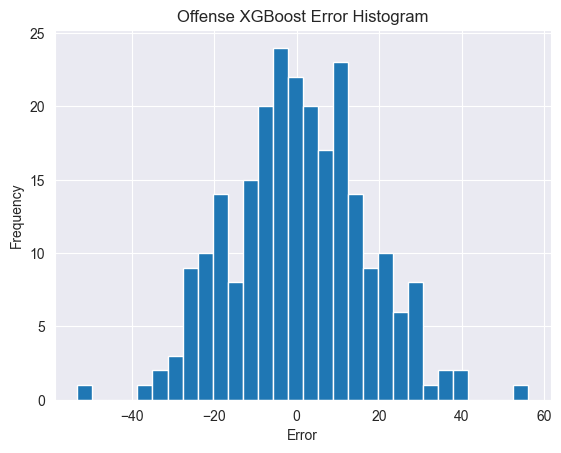

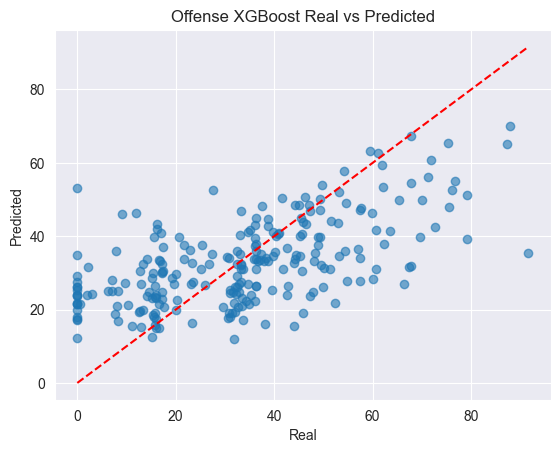

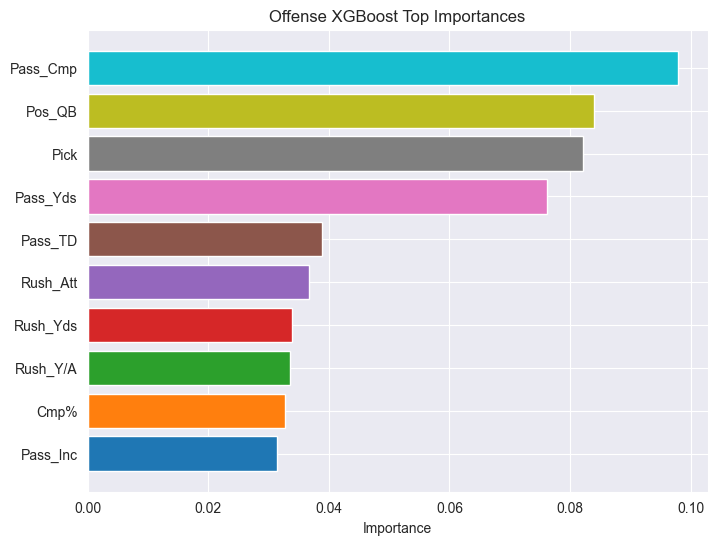

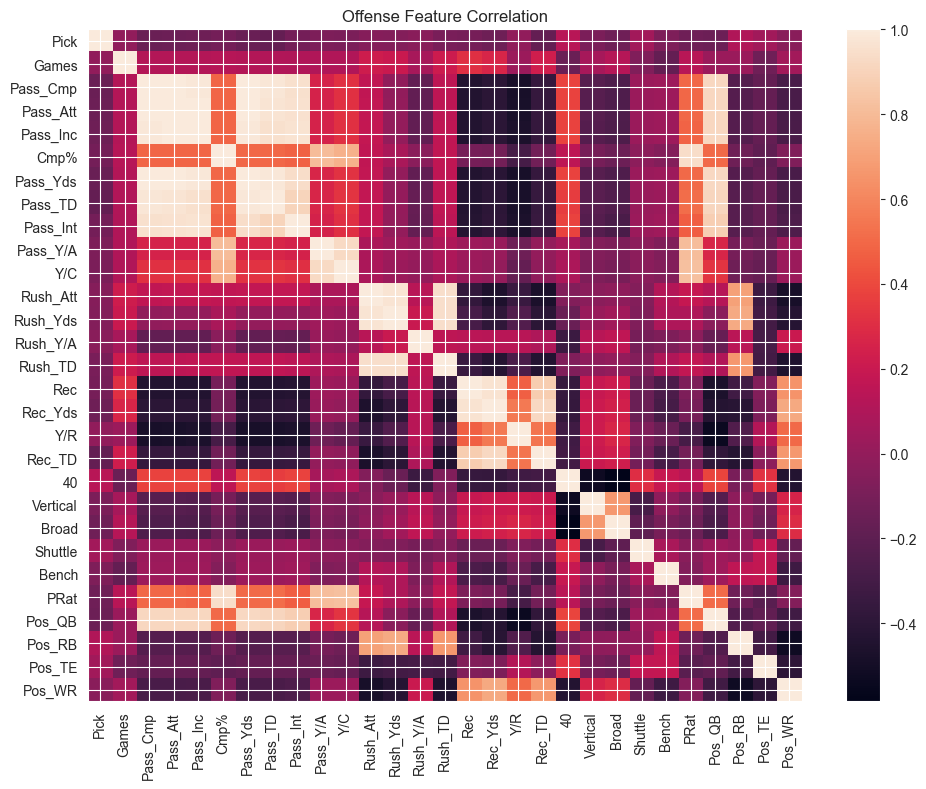

In [51]:
# Definir modelos ofensivos usando hiperparametros
off_models = {
    'DecisionTree': DecisionTreeRegressor(random_state=42,
                                          max_depth=10,
                                          min_samples_leaf=5,
                                          min_samples_split=125),
    'RandomForest': RandomForestRegressor(random_state=42,
                                          n_estimators=282,
                                          max_depth=5,
                                          min_samples_leaf=14,
                                          min_samples_split=5),
    'XGBoost': XGBRegressor(random_state=42,
                            objective='reg:squarederror',
                            colsample_bytree=0.7,
                            learning_rate=0.05,
                            max_depth=2,
                            n_estimators=100,
                            subsample=0.8)
}
off_results = {}

for name, model in off_models.items():
    metrics, pred = get_metrics(model, X_off_train_ref, y_off_train_ref, X_off_test_ref, y_off_test_ref)
    # Separar importances de las métricas
    importances = metrics.pop('Importances')
    off_results[name] = {'metrics': metrics, 'importances': importances}

    print(f"--- Offense {name} ---")
    # Mostrar tabla de métricas
    df_metrics = pd.DataFrame(metrics, index=['Value']).T
    print(df_metrics)
    
    # Evaluación con validación cruzada (R2)
    cv_scores = cross_val_score(model, X_off_refined, y_off, cv=5, scoring='r2')
    print(f"Cross-Validated R2 (mean ± std): {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")
    
    # Tabla Top y Bottom 10 importancias
    imp_table = table_top_bottom(importances, n=10)
    print("Top 10 y Bottom 10 Importances:")
    print(imp_table)

    # Gráficos
    plot_errors(y_off_test_ref, pred, f"Offense {name} Error Histogram")
    plot_real_pred(y_off_test_ref, pred, f"Offense {name} Real vs Predicted")
    plot_importances(importances, f"Offense {name} Top Importances")
    # Matriz de correlación solo para variables ofensivas (excluye Draft y posiciones defensivas)
    def_cols_off_corr = [c for c in X_off_refined.columns 
                        if not c.startswith('Draft')] 
    plot_corr(X_off_refined[def_cols_off_corr], "Offense Feature Correlation")

Refinamiento Defensivo

In [85]:
# ======================
# Refinamiento Defensivo: Eliminar estadísticas ofensivas irrelevantes
# ======================
irrelevant_off_vars = ['Pass_cmp', 'Pass_Att', 'Pass_Inc', 'Cmp%', 'Pass_Yds', 'Pass_TD', 'Pass_Int', 'Pass_Y/A', 'Y/C', 'Rush_Att', 'Rush_Yds', 'Rush_Y/A', 'Rush_TD', 'Rec', 'Rec_Yds', 'Y/R', 'Rec_TD', 'Pos_QB', 'Pos_WR', 'Pos_RB', 'Pos_TE', 'QPR']
def_refined_cols = [c for c in X_def.columns if not c.startswith('NFL' and 'Draft') and c not in irrelevant_off_vars]
X_def_refined = X_def[def_refined_cols]

X_def_train_ref, X_def_test_ref, y_def_train_ref, y_def_test_ref = train_test_split(
    X_def_refined, y_def, test_size=0.2, random_state=42
)

print("\n==== Modelos defensivos refinados ====")
for name, model in def_models.items():
    # Pipeline: escalado + modelo
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)
    ])
    
    # Validación cruzada con pipeline
    cv_scores = cross_val_score(pipeline, X_def_refined, y_def, cv=5, scoring='r2')
    print(f"\n--- DEFENSE (Refined) {name} ---")
    print(f"Cross-Validated R2 (mean ± std): {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")
    
    # Entrenamiento final para métricas fuera de CV
    pipeline.fit(X_def_train_ref, y_def_train_ref)
    pred = pipeline.predict(X_def_test_ref)
    metrics = {
        'Train_MAE': mean_absolute_error(y_def_train_ref, pipeline.predict(X_def_train_ref)),
        'Train_RMSE': np.sqrt(mean_squared_error(y_def_train_ref, pipeline.predict(X_def_train_ref))),
        'Train_R2': r2_score(y_def_train_ref, pipeline.predict(X_def_train_ref)),
        'Test_MAE': mean_absolute_error(y_def_test_ref, pred),
        'Test_RMSE': np.sqrt(mean_squared_error(y_def_test_ref, pred)),
        'Test_R2': r2_score(y_def_test_ref, pred)
    }
    print(pd.DataFrame(metrics, index=['Value']).T)


==== Modelos defensivos refinados ====

--- DEFENSE (Refined) DecisionTree ---
Cross-Validated R2 (mean ± std): 0.2624 ± 0.0641
                Value
Train_MAE   20.845268
Train_RMSE  25.213431
Train_R2     0.274170
Test_MAE    20.503992
Test_RMSE   24.765228
Test_R2      0.330973

--- DEFENSE (Refined) RandomForest ---
Cross-Validated R2 (mean ± std): 0.2916 ± 0.0618
                Value
Train_MAE    7.643269
Train_RMSE   9.450333
Train_R2     0.898032
Test_MAE    19.124979
Test_RMSE   23.632631
Test_R2      0.390768

--- DEFENSE (Refined) XGBoost ---
Cross-Validated R2 (mean ± std): 0.3060 ± 0.0610
                Value
Train_MAE   19.738591
Train_RMSE  23.807287
Train_R2     0.352871
Test_MAE    19.679795
Test_RMSE   23.875048
Test_R2      0.378205


Decision tree - Corregir sobreajuste

In [54]:
# Random Search - Decision Tree

dt_params = {
    'max_depth': [5, 10, 15, 30, 100, 1000],
    'min_samples_split': [2, 10, 50, 150, 1000],
    'min_samples_leaf': [2, 10, 50, 150, 1000]
}

dt_rand = RandomizedSearchCV(
    DecisionTreeRegressor(random_state=42),
    param_distributions=dt_params,
    n_iter=50,
    cv=5,
    scoring='r2',
    n_jobs=-1
)
dt_rand.fit(X_def_train_ref, y_def_train_ref)

print("Best DecisionTree params:", dt_rand.best_params_)
print("Best CV R2:", dt_rand.best_score_)

Best DecisionTree params: {'min_samples_split': 50, 'min_samples_leaf': 150, 'max_depth': 10}
Best CV R2: 0.2324964293905732


In [59]:
# Grid Search - Decision Tree

dt_params = {
    'max_depth': [2, 3, 4],
    'min_samples_leaf': [197, 198, 199],
    'min_samples_split': [8, 9, 10]
}

dt_grid = GridSearchCV(
    DecisionTreeRegressor(random_state=42),
    param_grid=dt_params,
    cv=5,
    scoring='r2',
    n_jobs=-1,
)
dt_grid.fit(X_def_train_ref, y_def_train_ref)

print("Best DecisionTree params:", dt_grid.best_params_)
print("Best CV R2:", dt_grid.best_score_)

Best DecisionTree params: {'max_depth': 3, 'min_samples_leaf': 198, 'min_samples_split': 9}
Best CV R2: 0.2377201244628714


XGBoost - Corregir sobreajuste

In [71]:
# Random Search - XGBoost
xgb_params = {
    'n_estimators': [100, 200, 50, 1000],
    'max_depth': [2, 10, 5, 100],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.8, 0.6, 0.9, 0.7],
    'colsample_bytree': [0.8, 0.6, 0.9, 0.7],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [1, 1.5, 2]
}

xgb_rand = RandomizedSearchCV(
    XGBRegressor(random_state=42, objective='reg:squarederror'),
    param_distributions=xgb_params,
    n_iter=1000,
    cv=5,
    scoring='r2',
    n_jobs=-1
)
xgb_rand.fit(X_def_train_ref, y_def_train_ref)

print("Best XGBoost params:", xgb_rand.best_params_)
print("Best CV R2:", xgb_rand.best_score_)

Best XGBoost params: {'subsample': 0.6, 'reg_lambda': 1.5, 'reg_alpha': 0, 'n_estimators': 100, 'max_depth': 2, 'learning_rate': 0.05, 'colsample_bytree': 0.9}
Best CV R2: 0.28510367306589535


In [75]:
# Grid Search - XGBoost
xgb_params = {
    'n_estimators': [75, 80, 70],
    'max_depth': [2],
    'learning_rate': [0.05, 0.06, 0.04],
    'subsample': [0.6],
    'colsample_bytree': [0.85],
    'reg_lambda': [1, 1.1, 1.2],
}

xgb_grid = GridSearchCV(
    XGBRegressor(random_state=42, objective='reg:squarederror'),
    param_grid=xgb_params,
    cv=5,
    scoring='r2',
    n_jobs=-1
)
xgb_grid.fit(X_def_train_ref, y_def_train_ref)

print("Best XGBoost params:", xgb_grid.best_params_)
print("Best CV R2:", xgb_grid.best_score_)

Best XGBoost params: {'colsample_bytree': 0.85, 'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 80, 'reg_lambda': 1, 'subsample': 0.6}
Best CV R2: 0.2870142690563296


# =========================
# Evaluación Defensiva Final
# =========================

--- Defense DecisionTree ---
                Value
Train_MAE   20.845268
Train_RMSE  25.213431
Train_R2     0.274170
Test_MAE    20.503992
Test_RMSE   24.765228
Test_R2      0.330973
Cross-Validated R2 (mean ± std): 0.2624 ± 0.0641
Top 10 y Bottom 10 Importances:
     Variable  BottomImportance                       Variable  TopImportance
0  Draft Year               0.0          DraftCollege_Virginia            0.0
1       Games               0.0     DraftCollege_Virginia Tech            0.0
2    Pass_Cmp               0.0  DraftCollege_Western Kentucky            0.0
3          Sk               0.0        DraftCollege_Washington            0.0
4         Ast               0.0  DraftCollege_Washington State            0.0
5        Solo               0.0     DraftCollege_West Virginia            0.0
6        Comb               0.0         DraftCollege_Wisconsin            0.0
7         TFL               0.0  DraftCollege_Western Michigan            0.0
8       Broad               0.0   

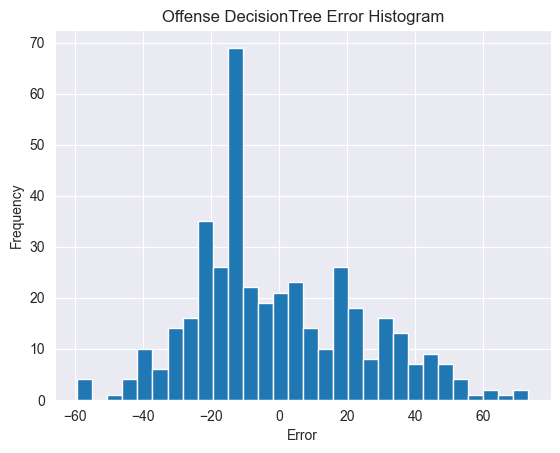

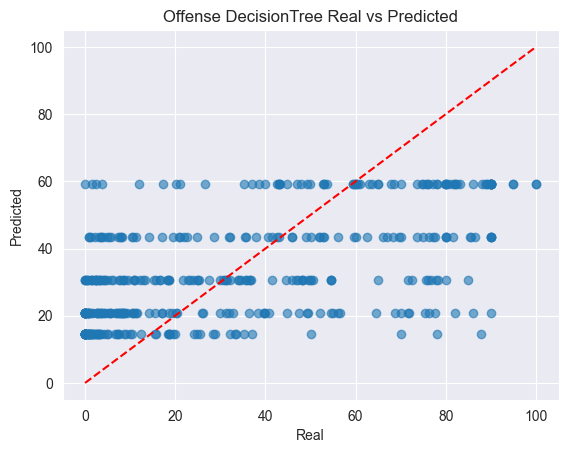

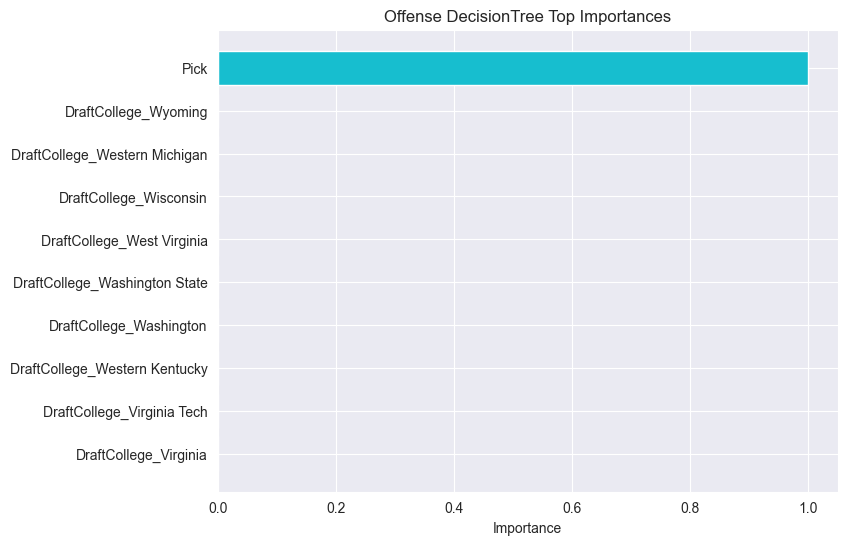

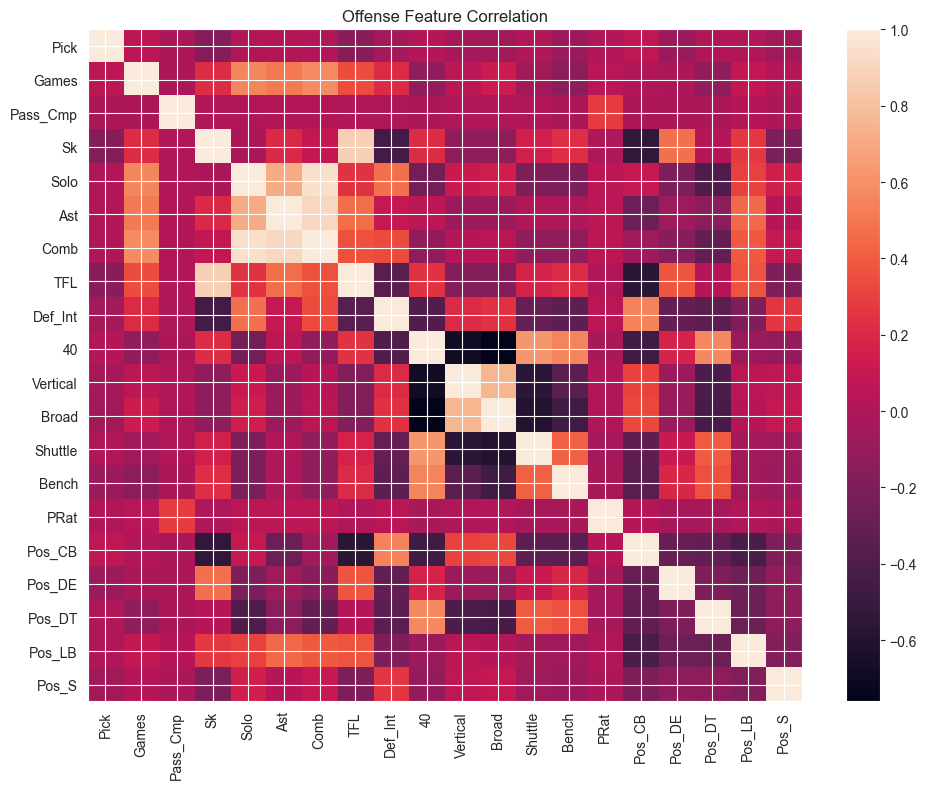

--- Defense RandomForest ---
                Value
Train_MAE    7.630909
Train_RMSE   9.586982
Train_R2     0.895062
Test_MAE    18.665747
Test_RMSE   23.390719
Test_R2      0.403176
Cross-Validated R2 (mean ± std): 0.2827 ± 0.0752
Top 10 y Bottom 10 Importances:
                              Variable  BottomImportance  Variable  \
0                 DraftCollege_Liberty      0.000000e+00   Shuttle   
1           DraftCollege_Georgia State      0.000000e+00        Sk   
2           DraftCollege_South Alabama      0.000000e+00     Bench   
3             DraftCollege_North Texas      0.000000e+00     Games   
4             DraftCollege_Texas State      0.000000e+00      Comb   
5                    DraftCollege_Army      1.678027e-08  Vertical   
6           DraftCollege_Massachusetts      5.643809e-07      Solo   
7                    DraftCollege_Navy      5.884654e-07       TFL   
8  DraftCollege_Middle Tennessee State      2.245104e-06       Ast   
9        DraftCollege_Central Michig

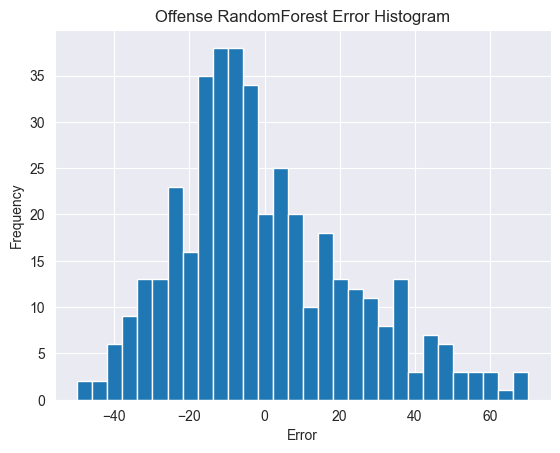

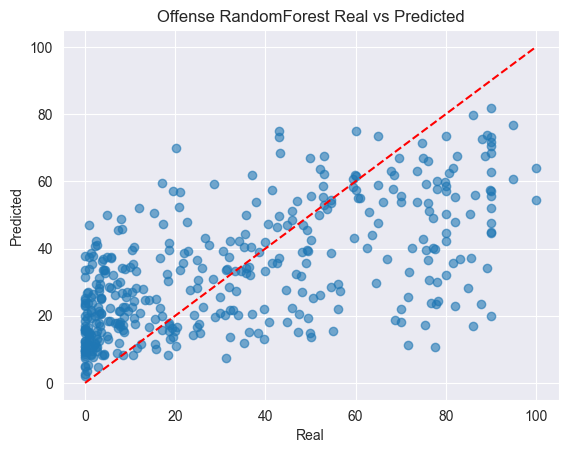

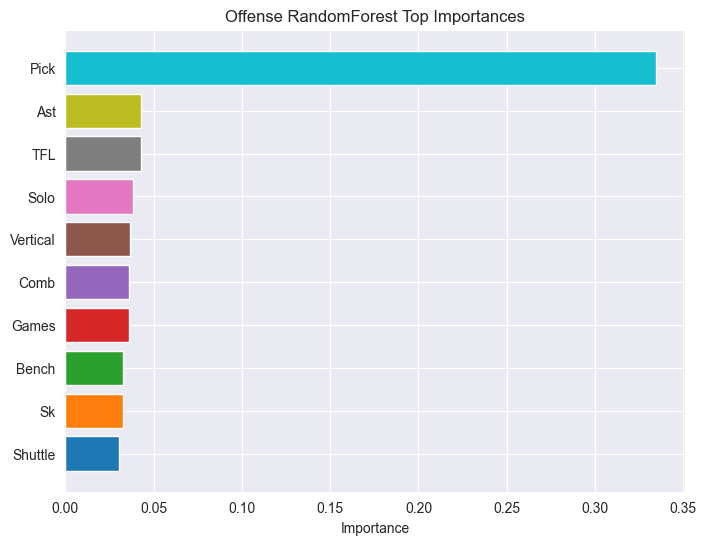

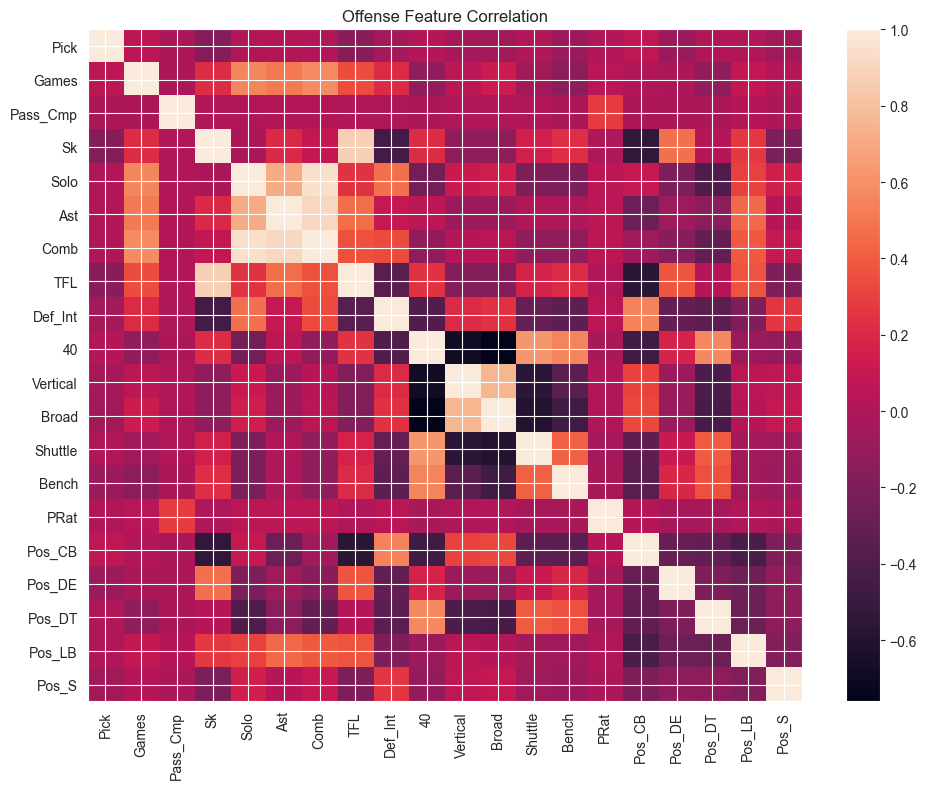

--- Defense XGBoost ---
                Value
Train_MAE   19.724422
Train_RMSE  23.804080
Train_R2     0.353045
Test_MAE    19.593542
Test_RMSE   23.847792
Test_R2      0.379624
Cross-Validated R2 (mean ± std): 0.3059 ± 0.0614
Top 10 y Bottom 10 Importances:
        Variable  BottomImportance Variable  TopImportance
0       Pass_Cmp               0.0       Sk       0.032964
1           PRat               0.0      Ast       0.034204
2  DraftTeam_CLE               0.0     Comb       0.034981
3  DraftTeam_CLT               0.0    Broad       0.035020
4  DraftTeam_DET               0.0   Pos_LB       0.036399
5  DraftTeam_DEN               0.0     Solo       0.036677
6  DraftTeam_DAL               0.0  Shuttle       0.039432
7  DraftTeam_CRD               0.0    Pos_S       0.039804
8  DraftTeam_CHI               0.0      TFL       0.048961
9  DraftTeam_CIN               0.0     Pick       0.156292


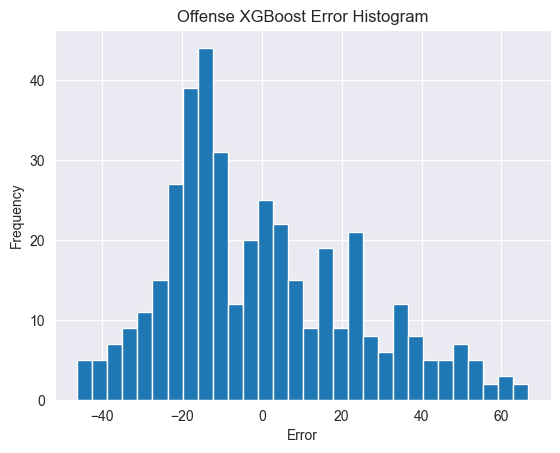

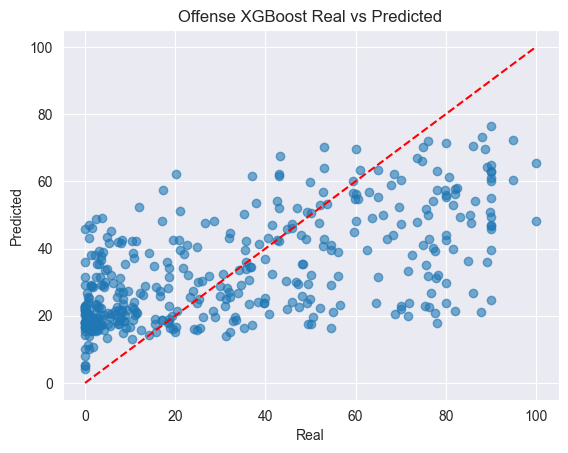

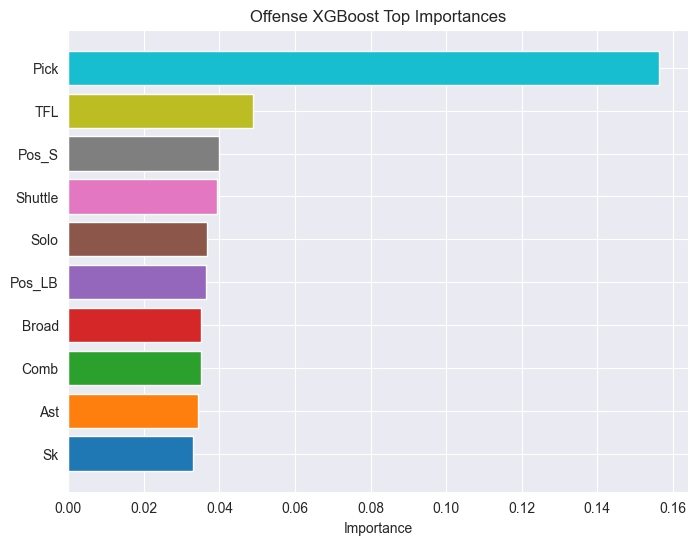

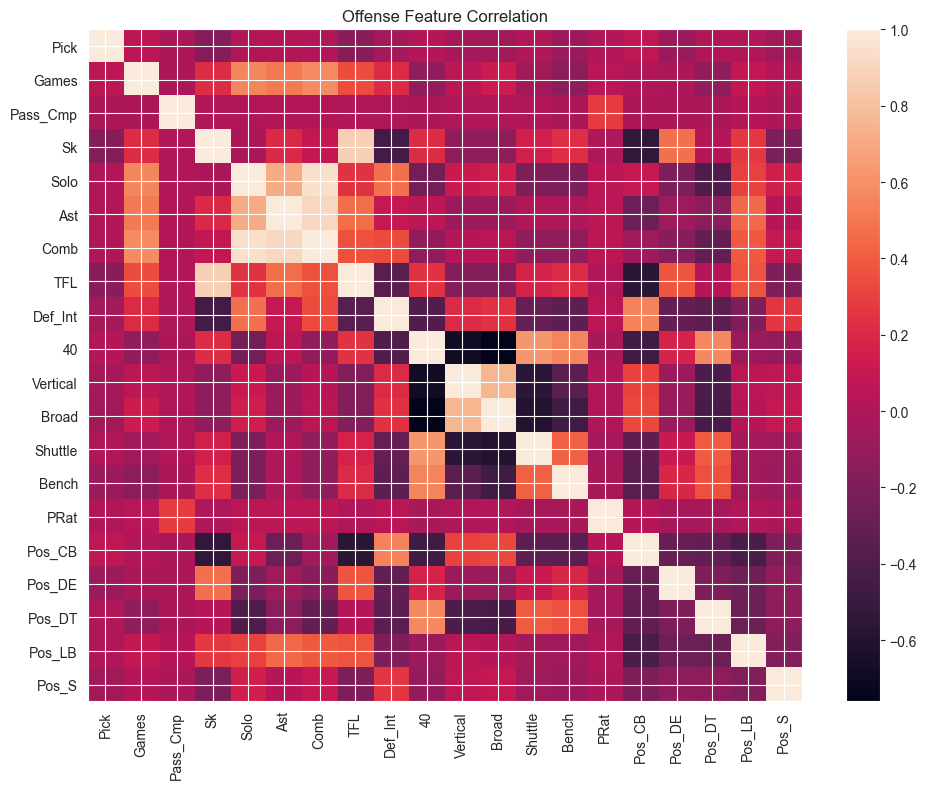

In [76]:
# Definir modelos defensivos usando hiperparametros
def_models = {
    'DecisionTree': DecisionTreeRegressor(random_state=42,
                                          max_depth=3,
                                          min_samples_leaf=198,
                                          min_samples_split=9),
    'RandomForest': RandomForestRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42,
                            objective='reg:squarederror',
                            colsample_bytree=0.85,
                            learning_rate=0.05,
                            max_depth=2,
                            n_estimators=80,
                            subsample=0.6)
}
def_results = {}

for name, model in def_models.items():
    metrics, pred = get_metrics(model, X_def_train_ref, y_def_train_ref, X_def_test_ref, y_def_test_ref)
    # Separar importances de las métricas
    importances = metrics.pop('Importances')
    def_results[name] = {'metrics': metrics, 'importances': importances}

    print(f"--- Defense {name} ---")
    # Mostrar tabla de métricas
    df_metrics = pd.DataFrame(metrics, index=['Value']).T
    print(df_metrics)

    # Evaluación con validación cruzada (R2)
    cv_scores = cross_val_score(model, X_def_refined, y_def, cv=5, scoring='r2')
    print(f"Cross-Validated R2 (mean ± std): {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")

    # Tabla Top y Bottom 10 importancias
    imp_table = table_top_bottom(importances, n=10)
    print("Top 10 y Bottom 10 Importances:")
    print(imp_table)

    # Gráficos
    plot_errors(y_def_test_ref, pred, f"Offense {name} Error Histogram")
    plot_real_pred(y_def_test_ref, pred, f"Offense {name} Real vs Predicted")
    plot_importances(importances, f"Offense {name} Top Importances")
    # Matriz de correlación solo para variables ofensivas (excluye Draft y posiciones defensivas)
    def_cols_off_corr = [c for c in X_def_refined.columns
                         if not c.startswith('Draft')]
    plot_corr(X_def_refined[def_cols_off_corr], "Offense Feature Correlation")

Matriz de Correlacion

Ataque

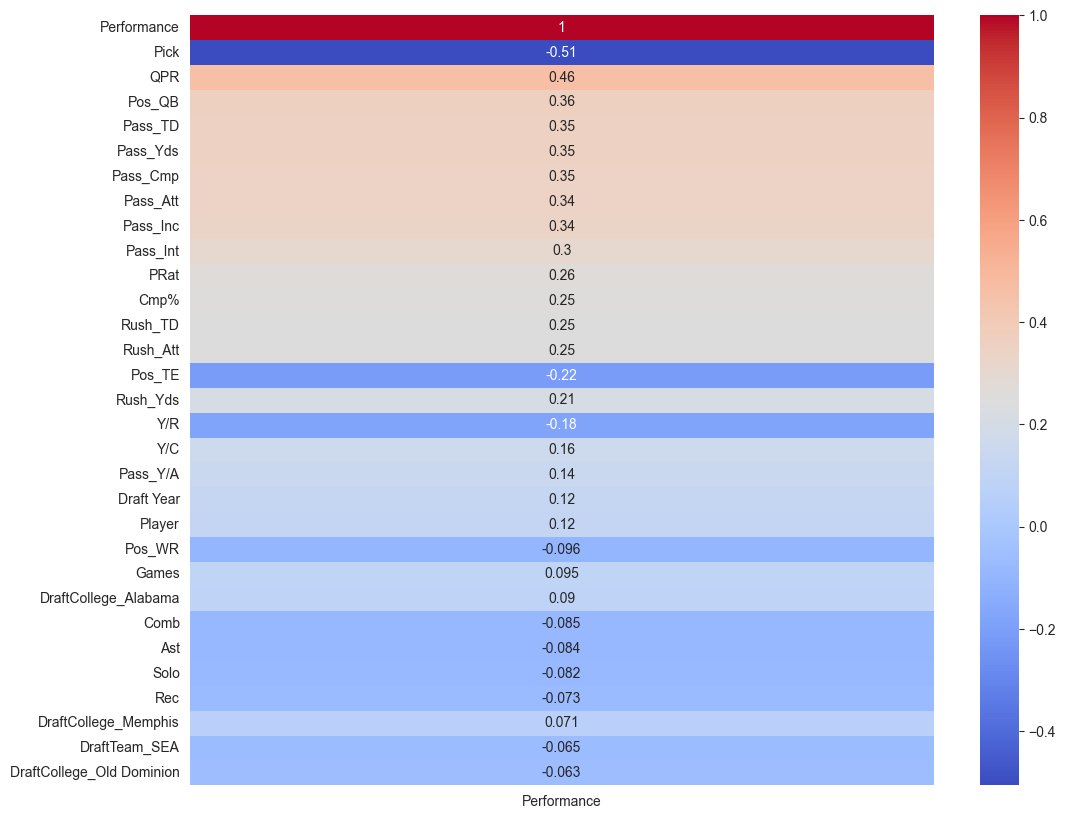

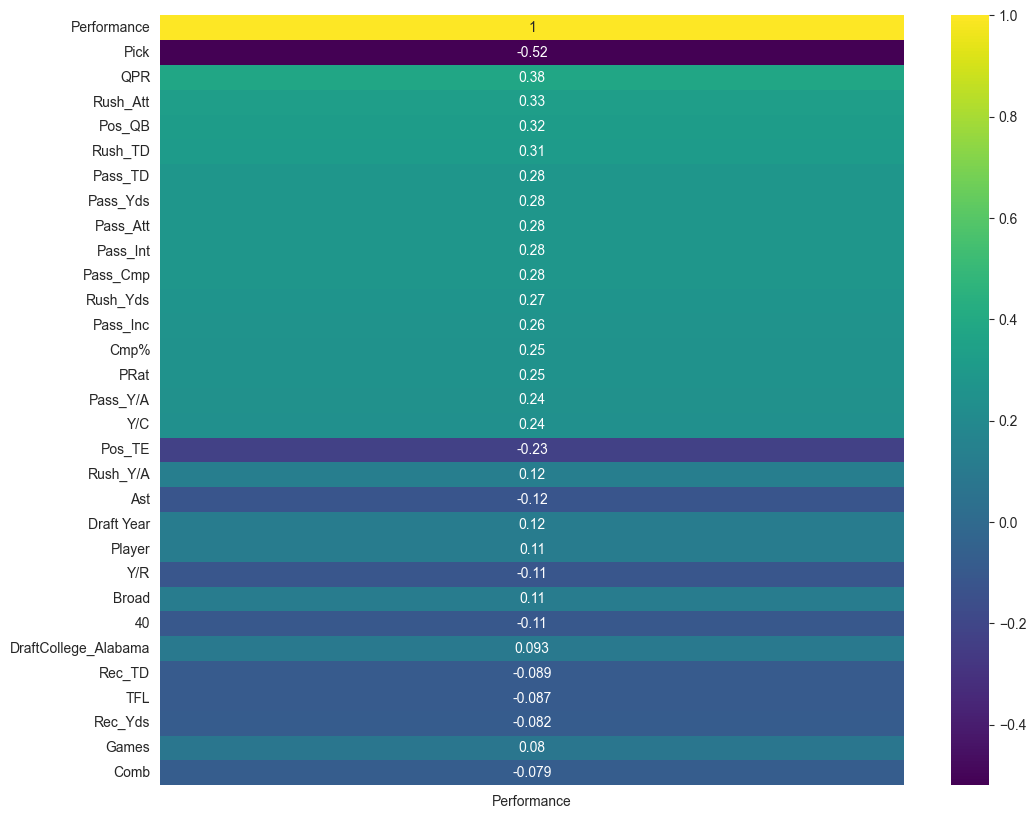

In [96]:
# Cargar datos
df = pd.read_csv("/Users/AlexLaugesen/repos/TFG1/venv/FINAL_DATA_offense.csv")
df = df.drop(columns=[col for col in df.columns if col.startswith('NFL') and col not in irrelevant_def_vars])

# Pearson - Top 30
pearson_corr = df.corr(numeric_only=True)
top_20_pearson = pearson_corr['Performance'].abs().sort_values(ascending=False).head(31).index  # incluye 'Performance'
plt.figure(figsize=(12, 10))
sns.heatmap(pearson_corr.loc[top_20_pearson, ['Performance']], annot=True, cmap='coolwarm')
plt.show()

# Spearman - Top 30
spearman_corr = df.corr(method='spearman', numeric_only=True)
top_20_spearman = spearman_corr['Performance'].abs().sort_values(ascending=False).head(31).index
plt.figure(figsize=(12, 10))
sns.heatmap(spearman_corr.loc[top_20_spearman, ['Performance']], annot=True, cmap='viridis')
plt.show()

Defensa

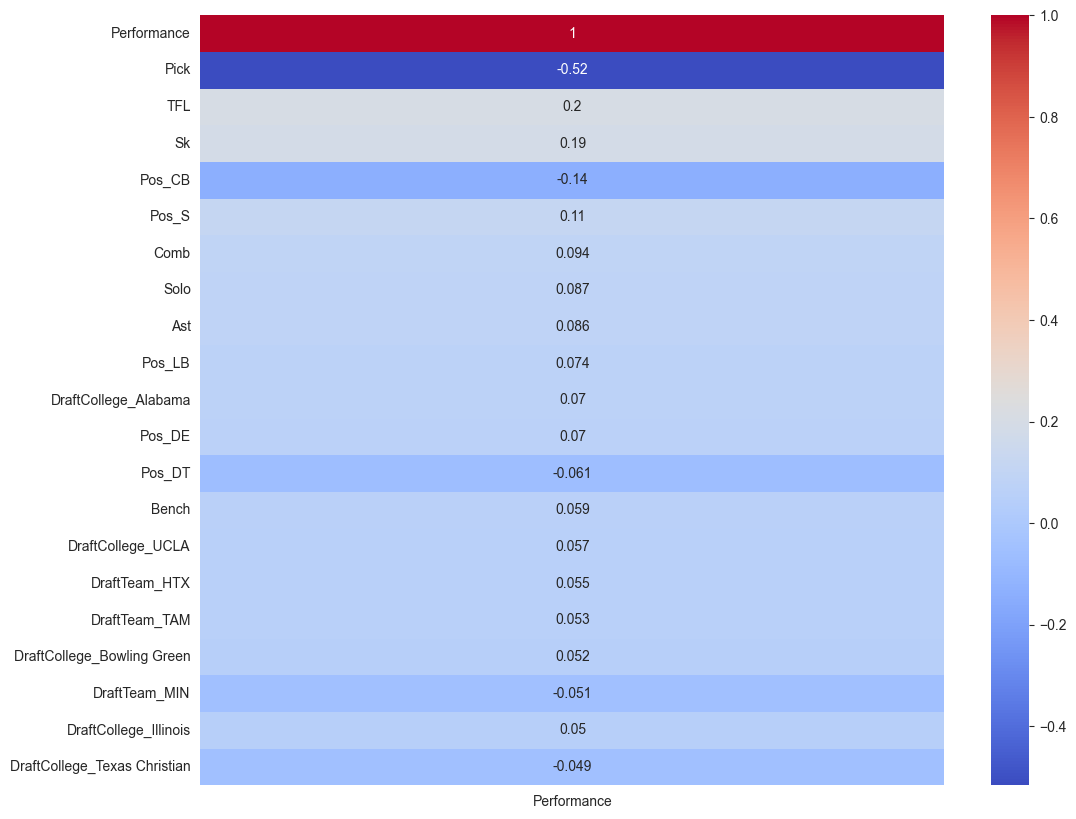

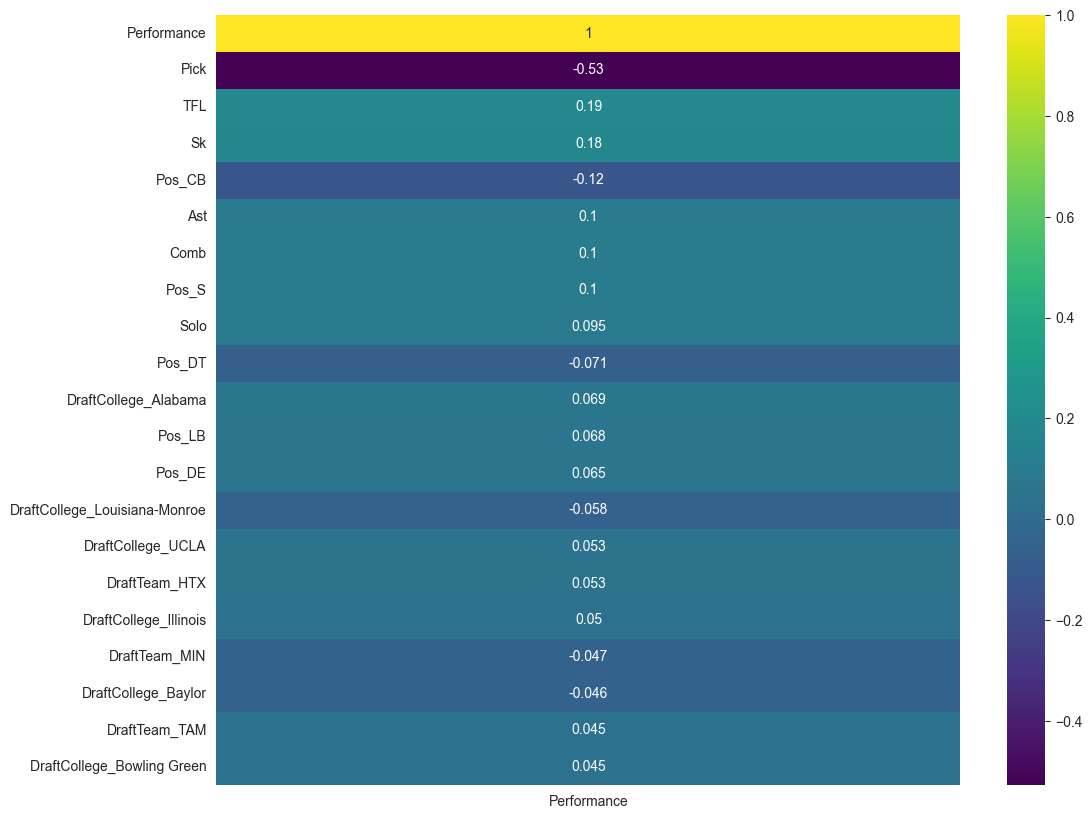

In [97]:
# Cargar datos
df = pd.read_csv("/Users/AlexLaugesen/repos/TFG1/venv/FINAL_DATA_defense.csv")
df = df.drop(columns=[col for col in df.columns if col.startswith('NFL') and col not in irrelevant_off_vars])

# Pearson - Top 20
pearson_corr = df.corr(numeric_only=True)
top_20_pearson = pearson_corr['Performance'].abs().sort_values(ascending=False).head(21).index  # incluye 'Performance'
plt.figure(figsize=(12, 10))
sns.heatmap(pearson_corr.loc[top_20_pearson, ['Performance']], annot=True, cmap='coolwarm')
plt.show()

# Spearman - Top 20
spearman_corr = df.corr(method='spearman', numeric_only=True)
top_20_spearman = spearman_corr['Performance'].abs().sort_values(ascending=False).head(21).index
plt.figure(figsize=(12, 10))
sns.heatmap(spearman_corr.loc[top_20_spearman, ['Performance']], annot=True, cmap='viridis')
plt.show()